In [34]:
import librosa
import librosa.display
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
valid_species = ['Asellia tridens', 'Eptesicus bottae', 'Myotis emarginatus', 'Pipistrellus kuhli', 'Rhinopoma muscatellum', 'Rhyneptesicus nasutus', 'Rousettus aegyptius', 'Taphozous perforatus']

In [3]:
audio_folder_name= r"data\Identified calls"

def getLength(sp,filename):
    audio_path = join(audio_folder_name, sp, filename)
    data, sr = librosa.load(audio_path, sr = 22050)
    return np.size(data,0)/22050

file_names = []
file_length = []
for sp in valid_species:
    curr_file_names = listdir(join(audio_folder_name,sp))
    for f in curr_file_names:
        if f.endswith('.WAV') or f.endswith('.wav'):
            file_names.append(f)
            file_length.append(getLength(sp,f))


In [4]:
df = pd.DataFrame(list(zip(file_names,file_length)),columns=['Filename','Length'])
df.head(4)

,Filename,Length
0,ASETRI_058_20180212_D1000.WAV,8.874331
1,ASETRI_058_20180212_D1000_10X.wav,31.903810
2,ASETRI_058_20180212_D240.wav,35.423492
3,ASETRI_20180118_D1000.wav,11.378186


In [7]:
def getSpecies(x):
    part = x.split('_')
    return part[0]

df['Species'] =df['Filename'].apply(getSpecies)

In [8]:
df.head(5)

,Filename,Length,Species
0,ASETRI_058_20180212_D1000.WAV,8.874331,ASETRI
1,ASETRI_058_20180212_D1000_10X.wav,31.903810,ASETRI
2,ASETRI_058_20180212_D240.wav,35.423492,ASETRI
3,ASETRI_20180118_D1000.wav,11.378186,ASETRI
4,EPTBOT_064_20180219_D1000.WAV,10.751655,EPTBOT


In [9]:
df.groupby(['Species']).sum()

,Length
Species,
ASETRI,87.579819
EPTBOT,463.257188
MYOEMA,404.946077
PIPKUH,1025.289070
RHIMUS,5306.306440
RHYNAS,859.880499
ROUAEG,394.939410
TAPPER,1477.148571


In [10]:
df.groupby(['Species']).mean()

,Length
Species,
ASETRI,21.894955
EPTBOT,77.209531
MYOEMA,44.994009
PIPKUH,64.080567
RHIMUS,54.145984
RHYNAS,57.325367
ROUAEG,26.329294
TAPPER,46.160893


In [11]:
df.groupby(['Species']).std()

,Length
Species,
ASETRI,13.703255
EPTBOT,82.919556
MYOEMA,37.357760
PIPKUH,70.307293
RHIMUS,60.711622
RHYNAS,53.583431
ROUAEG,15.936114
TAPPER,38.222288


In [12]:
df.groupby(['Species']).min()

,Filename,Length
Species,,
ASETRI,ASETRI_058_20180212_D1000.WAV,8.874331
EPTBOT,EPTBOT_064_20180219_D1000.WAV,10.751655
MYOEMA,MYOEMA_010_20180131_D1000.WAV,8.020998
PIPKUH,PIPKUH_002_20180128_D1000.WAV,7.508980
RHIMUS,RHIMUS_001_20180119_D1000.WAV,7.508980
RHYNAS,RHYNAS_035_20180206_D1000.WAV,8.020998
ROUAEG,ROUAEG_039_20180209_D1000.WAV,10.239637
TAPPER,TAPPER_012_20180204_D1000.WAV,12.628980


In [13]:
df.groupby(['Species']).max()

,Filename,Length
Species,,
ASETRI,ASETRI_20180118_D1000.wav,35.423492
EPTBOT,EPTBOT_065_20180219_D240.wav,232.106122
MYOEMA,MYOEMA_071_20180304_D240.wav,106.576100
PIPKUH,PIPKUH_066_20180222_D1000_10X.WAV,220.159456
RHIMUS,RHIMUS_059_20180212_D240.wav,413.942902
RHYNAS,RHYNAS_069_20180227_D240.wav,172.372789
ROUAEG,ROUAEG_072_20180304_D240.wav,65.427846
TAPPER,TAPPER_034_20180204_D240.wav,167.249615


# Convert to Spectrograms Images

In [54]:
def plot_signals(signals):
    fig, axes = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=True, figsize=(20,5))
    fig.suptitle('Time Series'+ list(signals.keys())[0], size=16)
    plt.plot(list(signals.values())[0])


In [2]:
def convert_single_audio_to_image(audio_path, image_path):
    data, sr = librosa.load(audio_path, sr = 44100)

    window_width =  0.025 #25 ms  window size 
    sliding = 0.01 #10ms stride 
    spec = librosa.feature.melspectrogram(y=data, sr=sr, n_fft = int(window_width*sr), hop_length =int(sliding*sr), fmax=sr/2)
    
    #Convert amplitude to decibels
    db_spec = librosa.power_to_db(spec, ref=np.max)
    
    for x in range(0, np.size(db_spec,1),300):
        fig = plt.figure()
        ax = plt.axes()
        #x.set_axis_off()
        
        #if there is no more data, slide a bit backwards
        if(x+300 > np.size(db_spec,1)):
            limit = np.size(db_spec,1)
            librosa.display.specshow(np.reshape(np.copy(db_spec[:,limit-300:limit]),(128,-1)), sr=sr, hop_length =int(sliding*sr),fmax=sr/2, x_axis='time',y_axis='mel')
        else:
            librosa.display.specshow(np.reshape(np.copy(db_spec[:,x:x+300]),(128,-1)), sr=sr, hop_length =int(sliding*sr),fmax=sr/2, x_axis='time',y_axis='mel')
        
        plt.colorbar()
        file_end = "%d.png" %(x)
        #fig.savefig(image_path.replace('.png',file_end),bbox_inches='tight', transparent=True, pad_inches=0.0)
        fig.savefig(image_path.replace('.png',file_end))
        plt.close(fig)


In [ ]:
def split(split_list):
    a =0
    

In [3]:
valid_species = ['Asellia tridens', 'Eptesicus bottae', 'Myotis emarginatus', 'Pipistrellus kuhli', 'Rhinopoma muscatellum', 'Rhyneptesicus nasutus', 'Rousettus aegyptius', 'Taphozous perforatus']

audio_folder_name= r"data\Identified calls"
image_folder_name=  r"data\speclab"
for sp in valid_species:
    curr_file_names = listdir(join(audio_folder_name,sp))
    print("count of Wav_files in {}= {}".format(len(curr_file_names),sp))
    for f in curr_file_names:
        if f.endswith('.WAV') or f.endswith('.wav'):
            audio_path = join(audio_folder_name,sp,f)
            all_caps_file_name = f.upper()
            image_path = join(image_folder_name,all_caps_file_name.replace('.WAV', '.png'))
            convert_single_audio_to_image(audio_path,image_path)
            #signal ={f:data}
            #plot_signals(signal)


count of Wav_files in 5= Asellia tridens
count of Wav_files in 6= Eptesicus bottae
count of Wav_files in 9= Myotis emarginatus
count of Wav_files in 16= Pipistrellus kuhli
count of Wav_files in 99= Rhinopoma muscatellum
count of Wav_files in 15= Rhyneptesicus nasutus
count of Wav_files in 15= Rousettus aegyptius
count of Wav_files in 32= Taphozous perforatus


# Convert to Raw Array Spectrograms

In [35]:
curr_file_names = ['ASETRI_058_20180212_D1000_10X0.png', 'ASETRI_058_20180212_D1000_10X1200.png', 'ASETRI_058_20180212_D1000_10X1500.png', 'ASETRI_058_20180212_D1000_10X1800.png', 'ASETRI_058_20180212_D1000_10X2100.png', 'ASETRI_058_20180212_D1000_10X2400.png', 'ASETRI_058_20180212_D1000_10X2700.png', 'ASETRI_058_20180212_D1000_10X300.png', 'ASETRI_058_20180212_D1000_10X3000.png', 'ASETRI_058_20180212_D1000_10X600.png', 'ASETRI_058_20180212_D1000_10X900.png', 'ASETRI_058_20180212_D2400.png', 'ASETRI_058_20180212_D2401800.png', 'ASETRI_058_20180212_D2402100.png', 'ASETRI_058_20180212_D2402400.png', 'ASETRI_058_20180212_D2402700.png', 'ASETRI_058_20180212_D240300.png', 'ASETRI_058_20180212_D2403000.png', 'ASETRI_058_20180212_D2403300.png', 'ASETRI_058_20180212_D240600.png', 'ASETRI_058_20180212_D240900.png', 'ASETRI_20180118_D10000.png', 'ASETRI_20180118_D1000300.png', 'ASETRI_20180118_D1000600.png', 'ASETRI_20180118_D1000900.png', 'EPTBOT_064_20180219_D1000300.png', 'EPTBOT_064_20180219_D1000600.png', 'EPTBOT_064_20180219_D1000900.png', 'EPTBOT_064_20180219_D1000_10X0.png', 'EPTBOT_064_20180219_D1000_10X10200.png', 'EPTBOT_064_20180219_D1000_10X10500.png', 'EPTBOT_064_20180219_D1000_10X1200.png', 'EPTBOT_064_20180219_D1000_10X1500.png', 'EPTBOT_064_20180219_D1000_10X1800.png', 'EPTBOT_064_20180219_D1000_10X2100.png', 'EPTBOT_064_20180219_D1000_10X2400.png', 'EPTBOT_064_20180219_D1000_10X2700.png', 'EPTBOT_064_20180219_D1000_10X300.png', 'EPTBOT_064_20180219_D1000_10X3000.png', 'EPTBOT_064_20180219_D1000_10X3300.png', 'EPTBOT_064_20180219_D1000_10X3600.png', 'EPTBOT_064_20180219_D1000_10X3900.png', 'EPTBOT_064_20180219_D1000_10X4200.png', 'EPTBOT_064_20180219_D1000_10X4500.png', 'EPTBOT_064_20180219_D1000_10X4800.png', 'EPTBOT_064_20180219_D1000_10X5100.png', 'EPTBOT_064_20180219_D1000_10X5400.png', 'EPTBOT_064_20180219_D1000_10X5700.png', 'EPTBOT_064_20180219_D1000_10X600.png', 'EPTBOT_064_20180219_D1000_10X6000.png', 'EPTBOT_064_20180219_D1000_10X6300.png', 'EPTBOT_064_20180219_D1000_10X6900.png', 'EPTBOT_064_20180219_D1000_10X7200.png', 'EPTBOT_064_20180219_D1000_10X7500.png', 'EPTBOT_064_20180219_D1000_10X7800.png', 'EPTBOT_064_20180219_D1000_10X8100.png', 'EPTBOT_064_20180219_D1000_10X900.png', 'EPTBOT_064_20180219_D1000_10X9000.png', 'EPTBOT_064_20180219_D1000_10X9300.png', 'EPTBOT_064_20180219_D1000_10X9600.png', 'EPTBOT_064_20180219_D1000_10X9900.png', 'EPTBOT_064_20180219_D2401200.png', 'EPTBOT_064_20180219_D2401500.png', 'EPTBOT_064_20180219_D2401800.png', 'EPTBOT_064_20180219_D2402100.png', 'EPTBOT_064_20180219_D2402400.png', 'EPTBOT_064_20180219_D2402700.png', 'EPTBOT_064_20180219_D240300.png', 'EPTBOT_064_20180219_D2403000.png', 'EPTBOT_064_20180219_D2403600.png', 'EPTBOT_064_20180219_D2404500.png', 'EPTBOT_064_20180219_D2404800.png', 'EPTBOT_064_20180219_D240600.png', 'EPTBOT_064_20180219_D240900.png', 'EPTBOT_065_20180219_D10001200.png', 'EPTBOT_065_20180219_D10001500.png', 'EPTBOT_065_20180219_D1000300.png', 'EPTBOT_065_20180219_D1000600.png', 'EPTBOT_065_20180219_D1000900.png', 'EPTBOT_065_20180219_D1000_10X0.png', 'EPTBOT_065_20180219_D1000_10X10200.png', 'EPTBOT_065_20180219_D1000_10X10500.png', 'EPTBOT_065_20180219_D1000_10X10800.png', 'EPTBOT_065_20180219_D1000_10X11100.png', 'EPTBOT_065_20180219_D1000_10X11400.png', 'EPTBOT_065_20180219_D1000_10X11700.png', 'EPTBOT_065_20180219_D1000_10X1200.png', 'EPTBOT_065_20180219_D1000_10X12000.png', 'EPTBOT_065_20180219_D1000_10X12300.png', 'EPTBOT_065_20180219_D1000_10X12600.png', 'EPTBOT_065_20180219_D1000_10X12900.png', 'EPTBOT_065_20180219_D1000_10X13200.png', 'EPTBOT_065_20180219_D1000_10X14100.png', 'EPTBOT_065_20180219_D1000_10X1500.png', 'EPTBOT_065_20180219_D1000_10X15000.png', 'EPTBOT_065_20180219_D1000_10X15300.png', 'EPTBOT_065_20180219_D1000_10X15600.png', 'EPTBOT_065_20180219_D1000_10X15900.png', 'EPTBOT_065_20180219_D1000_10X16200.png', 'EPTBOT_065_20180219_D1000_10X16800.png', 'EPTBOT_065_20180219_D1000_10X17100.png', 'EPTBOT_065_20180219_D1000_10X17700.png', 'EPTBOT_065_20180219_D1000_10X1800.png', 'EPTBOT_065_20180219_D1000_10X18000.png', 'EPTBOT_065_20180219_D1000_10X18300.png', 'EPTBOT_065_20180219_D1000_10X18600.png', 'EPTBOT_065_20180219_D1000_10X18900.png', 'EPTBOT_065_20180219_D1000_10X19500.png', 'EPTBOT_065_20180219_D1000_10X19800.png', 'EPTBOT_065_20180219_D1000_10X20100.png', 'EPTBOT_065_20180219_D1000_10X20400.png', 'EPTBOT_065_20180219_D1000_10X2100.png', 'EPTBOT_065_20180219_D1000_10X2400.png', 'EPTBOT_065_20180219_D1000_10X2700.png', 'EPTBOT_065_20180219_D1000_10X300.png', 'EPTBOT_065_20180219_D1000_10X3000.png', 'EPTBOT_065_20180219_D1000_10X3300.png', 'EPTBOT_065_20180219_D1000_10X3600.png', 'EPTBOT_065_20180219_D1000_10X3900.png', 'EPTBOT_065_20180219_D1000_10X4200.png', 'EPTBOT_065_20180219_D1000_10X4500.png', 'EPTBOT_065_20180219_D1000_10X4800.png', 'EPTBOT_065_20180219_D1000_10X5100.png', 'EPTBOT_065_20180219_D1000_10X5400.png', 'EPTBOT_065_20180219_D1000_10X5700.png', 'EPTBOT_065_20180219_D1000_10X600.png', 'EPTBOT_065_20180219_D1000_10X6000.png', 'EPTBOT_065_20180219_D1000_10X6300.png', 'EPTBOT_065_20180219_D1000_10X6600.png', 'EPTBOT_065_20180219_D1000_10X6900.png', 'EPTBOT_065_20180219_D1000_10X7200.png', 'EPTBOT_065_20180219_D1000_10X7500.png', 'EPTBOT_065_20180219_D1000_10X7800.png', 'EPTBOT_065_20180219_D1000_10X8100.png', 'EPTBOT_065_20180219_D1000_10X8400.png', 'EPTBOT_065_20180219_D1000_10X8700.png', 'EPTBOT_065_20180219_D1000_10X900.png', 'EPTBOT_065_20180219_D1000_10X9000.png', 'EPTBOT_065_20180219_D1000_10X9300.png', 'EPTBOT_065_20180219_D1000_10X9600.png', 'EPTBOT_065_20180219_D1000_10X9900.png', 'EPTBOT_065_20180219_D2400.png', 'EPTBOT_065_20180219_D2402100.png', 'EPTBOT_065_20180219_D2402400.png', 'EPTBOT_065_20180219_D2402700.png', 'EPTBOT_065_20180219_D2403000.png', 'EPTBOT_065_20180219_D2403300.png', 'EPTBOT_065_20180219_D2403600.png', 'EPTBOT_065_20180219_D2403900.png', 'MYOEMA_010_20180131_D10000.png', 'MYOEMA_010_20180131_D10001500.png', 'MYOEMA_010_20180131_D1000300.png', 'MYOEMA_010_20180131_D1000600.png', 'MYOEMA_010_20180131_D1000900.png', 'MYOEMA_010_20180131_D1000_10X0.png', 'MYOEMA_010_20180131_D1000_10X10200.png', 'MYOEMA_010_20180131_D1000_10X10500.png', 'MYOEMA_010_20180131_D1000_10X1200.png', 'MYOEMA_010_20180131_D1000_10X1500.png', 'MYOEMA_010_20180131_D1000_10X1800.png', 'MYOEMA_010_20180131_D1000_10X2100.png', 'MYOEMA_010_20180131_D1000_10X2400.png', 'MYOEMA_010_20180131_D1000_10X2700.png', 'MYOEMA_010_20180131_D1000_10X300.png', 'MYOEMA_010_20180131_D1000_10X3000.png', 'MYOEMA_010_20180131_D1000_10X3300.png', 'MYOEMA_010_20180131_D1000_10X3600.png', 'MYOEMA_010_20180131_D1000_10X3900.png', 'MYOEMA_010_20180131_D1000_10X4200.png', 'MYOEMA_010_20180131_D1000_10X4500.png', 'MYOEMA_010_20180131_D1000_10X4800.png', 'MYOEMA_010_20180131_D1000_10X5100.png', 'MYOEMA_010_20180131_D1000_10X5400.png', 'MYOEMA_010_20180131_D1000_10X5700.png', 'MYOEMA_010_20180131_D1000_10X600.png', 'MYOEMA_010_20180131_D1000_10X6000.png', 'MYOEMA_010_20180131_D1000_10X6300.png', 'MYOEMA_010_20180131_D1000_10X6600.png', 'MYOEMA_010_20180131_D1000_10X7200.png', 'MYOEMA_010_20180131_D1000_10X7500.png', 'MYOEMA_010_20180131_D1000_10X7800.png', 'MYOEMA_010_20180131_D1000_10X8100.png', 'MYOEMA_010_20180131_D1000_10X8400.png', 'MYOEMA_010_20180131_D1000_10X8700.png', 'MYOEMA_010_20180131_D1000_10X900.png', 'MYOEMA_010_20180131_D1000_10X9000.png', 'MYOEMA_010_20180131_D1000_10X9300.png', 'MYOEMA_010_20180131_D1000_10X9600.png', 'MYOEMA_010_20180131_D1000_10X9900.png', 'MYOEMA_010_20180131_D2401200.png', 'MYOEMA_010_20180131_D2401500.png', 'MYOEMA_010_20180131_D2401800.png', 'MYOEMA_010_20180131_D2402100.png', 'MYOEMA_010_20180131_D240300.png', 'MYOEMA_010_20180131_D240600.png', 'MYOEMA_010_20180131_D240900.png', 'MYOEMA_070_20180301_D10000.png', 'MYOEMA_070_20180301_D1000300.png', 'MYOEMA_070_20180301_D1000600.png', 'MYOEMA_070_20180301_D1000_10X0.png', 'MYOEMA_070_20180301_D1000_10X1200.png', 'MYOEMA_070_20180301_D1000_10X1500.png', 'MYOEMA_070_20180301_D1000_10X1800.png', 'MYOEMA_070_20180301_D1000_10X2100.png', 'MYOEMA_070_20180301_D1000_10X2400.png', 'MYOEMA_070_20180301_D1000_10X2700.png', 'MYOEMA_070_20180301_D1000_10X300.png', 'MYOEMA_070_20180301_D1000_10X3000.png', 'MYOEMA_070_20180301_D1000_10X3300.png', 'MYOEMA_070_20180301_D1000_10X3600.png', 'MYOEMA_070_20180301_D1000_10X3900.png', 'MYOEMA_070_20180301_D1000_10X4200.png', 'MYOEMA_070_20180301_D1000_10X4500.png', 'MYOEMA_070_20180301_D1000_10X4800.png', 'MYOEMA_070_20180301_D1000_10X5100.png', 'MYOEMA_070_20180301_D1000_10X5400.png', 'MYOEMA_070_20180301_D1000_10X5700.png', 'MYOEMA_070_20180301_D1000_10X600.png', 'MYOEMA_070_20180301_D1000_10X6000.png', 'MYOEMA_070_20180301_D1000_10X6300.png', 'MYOEMA_070_20180301_D1000_10X6600.png', 'MYOEMA_070_20180301_D1000_10X900.png', 'MYOEMA_070_20180301_D2401200.png', 'MYOEMA_070_20180301_D2401500.png', 'MYOEMA_070_20180301_D2401800.png', 'MYOEMA_070_20180301_D2402100.png', 'MYOEMA_070_20180301_D2403000.png', 'MYOEMA_070_20180301_D2403300.png', 'MYOEMA_071_20180304_D10000.png', 'MYOEMA_071_20180304_D1000300.png', 'MYOEMA_071_20180304_D1000600.png', 'MYOEMA_071_20180304_D1000_10X0.png', 'MYOEMA_071_20180304_D1000_10X1200.png', 'MYOEMA_071_20180304_D1000_10X1500.png', 'MYOEMA_071_20180304_D1000_10X1800.png', 'MYOEMA_071_20180304_D1000_10X2100.png', 'MYOEMA_071_20180304_D1000_10X2400.png', 'MYOEMA_071_20180304_D1000_10X2700.png', 'MYOEMA_071_20180304_D1000_10X300.png', 'MYOEMA_071_20180304_D1000_10X600.png', 'MYOEMA_071_20180304_D1000_10X900.png', 'MYOEMA_071_20180304_D2400.png', 'MYOEMA_071_20180304_D2401500.png', 'MYOEMA_071_20180304_D2402700.png', 'MYOEMA_071_20180304_D2403000.png', 'MYOEMA_071_20180304_D2404200.png', 'MYOEMA_071_20180304_D2404500.png', 'MYOEMA_071_20180304_D2404800.png', 'MYOEMA_071_20180304_D2405100.png', 'MYOEMA_071_20180304_D2405700.png', 'MYOEMA_071_20180304_D2406300.png', 'MYOEMA_071_20180304_D2406600.png', 'MYOEMA_071_20180304_D2406900.png', 'MYOEMA_071_20180304_D2407200.png', 'MYOEMA_071_20180304_D2407500.png', 'MYOEMA_071_20180304_D2407800.png', 'MYOEMA_071_20180304_D2408100.png', 'MYOEMA_071_20180304_D2408400.png', 'MYOEMA_071_20180304_D2408700.png', 'MYOEMA_071_20180304_D2409600.png', 'MYOEMA_071_20180304_D2409900.png', 'PIPKUH_002_20180128_D10001200.png', 'PIPKUH_002_20180128_D10001500.png', 'PIPKUH_002_20180128_D10001800.png', 'PIPKUH_002_20180128_D1000300.png', 'PIPKUH_002_20180128_D1000_10X10200.png', 'PIPKUH_002_20180128_D1000_10X10500.png', 'PIPKUH_002_20180128_D1000_10X10800.png', 'PIPKUH_002_20180128_D1000_10X11100.png', 'PIPKUH_002_20180128_D1000_10X11400.png', 'PIPKUH_002_20180128_D1000_10X11700.png', 'PIPKUH_002_20180128_D1000_10X12000.png', 'PIPKUH_002_20180128_D1000_10X12300.png', 'PIPKUH_002_20180128_D1000_10X12600.png', 'PIPKUH_002_20180128_D1000_10X12900.png', 'PIPKUH_002_20180128_D1000_10X13200.png', 'PIPKUH_002_20180128_D1000_10X13500.png', 'PIPKUH_002_20180128_D1000_10X13800.png', 'PIPKUH_002_20180128_D1000_10X14100.png', 'PIPKUH_002_20180128_D1000_10X14400.png', 'PIPKUH_002_20180128_D1000_10X14700.png', 'PIPKUH_002_20180128_D1000_10X15000.png', 'PIPKUH_002_20180128_D1000_10X15300.png', 'PIPKUH_002_20180128_D1000_10X15900.png', 'PIPKUH_002_20180128_D1000_10X16200.png', 'PIPKUH_002_20180128_D1000_10X16500.png', 'PIPKUH_002_20180128_D1000_10X16800.png', 'PIPKUH_002_20180128_D1000_10X17100.png', 'PIPKUH_002_20180128_D1000_10X17700.png', 'PIPKUH_002_20180128_D1000_10X18000.png', 'PIPKUH_002_20180128_D1000_10X18600.png', 'PIPKUH_002_20180128_D1000_10X18900.png', 'PIPKUH_002_20180128_D1000_10X19200.png', 'PIPKUH_002_20180128_D1000_10X2700.png', 'PIPKUH_002_20180128_D1000_10X3000.png', 'PIPKUH_002_20180128_D1000_10X3300.png', 'PIPKUH_002_20180128_D1000_10X3600.png', 'PIPKUH_002_20180128_D1000_10X3900.png', 'PIPKUH_002_20180128_D1000_10X4200.png', 'PIPKUH_002_20180128_D1000_10X4500.png', 'PIPKUH_002_20180128_D1000_10X4800.png', 'PIPKUH_002_20180128_D1000_10X5100.png', 'PIPKUH_002_20180128_D1000_10X5400.png', 'PIPKUH_002_20180128_D1000_10X5700.png', 'PIPKUH_002_20180128_D1000_10X6000.png', 'PIPKUH_002_20180128_D1000_10X6300.png', 'PIPKUH_002_20180128_D1000_10X6600.png', 'PIPKUH_002_20180128_D1000_10X6900.png', 'PIPKUH_002_20180128_D1000_10X7200.png', 'PIPKUH_002_20180128_D1000_10X7500.png', 'PIPKUH_002_20180128_D1000_10X7800.png', 'PIPKUH_002_20180128_D1000_10X8100.png', 'PIPKUH_002_20180128_D1000_10X8400.png', 'PIPKUH_002_20180128_D1000_10X8700.png', 'PIPKUH_002_20180128_D1000_10X9000.png', 'PIPKUH_002_20180128_D1000_10X9300.png', 'PIPKUH_002_20180128_D1000_10X9600.png', 'PIPKUH_002_20180128_D1000_10X9900.png', 'PIPKUH_002_20180128_D2400.png', 'PIPKUH_002_20180128_D2401200.png', 'PIPKUH_002_20180128_D2401500.png', 'PIPKUH_002_20180128_D2401800.png', 'PIPKUH_002_20180128_D2402100.png', 'PIPKUH_002_20180128_D2402400.png', 'PIPKUH_002_20180128_D2402700.png', 'PIPKUH_002_20180128_D240300.png', 'PIPKUH_002_20180128_D2403000.png', 'PIPKUH_002_20180128_D2403300.png', 'PIPKUH_002_20180128_D240600.png', 'PIPKUH_002_20180128_D240900.png', 'PIPKUH_037_20180208_D1000_10X0.png', 'PIPKUH_037_20180208_D1000_10X1200.png', 'PIPKUH_037_20180208_D1000_10X1500.png', 'PIPKUH_037_20180208_D1000_10X1800.png', 'PIPKUH_037_20180208_D1000_10X2100.png', 'PIPKUH_037_20180208_D1000_10X2400.png', 'PIPKUH_037_20180208_D1000_10X2700.png', 'PIPKUH_037_20180208_D1000_10X300.png', 'PIPKUH_037_20180208_D1000_10X3000.png', 'PIPKUH_037_20180208_D1000_10X3300.png', 'PIPKUH_037_20180208_D1000_10X3600.png', 'PIPKUH_037_20180208_D1000_10X3900.png', 'PIPKUH_037_20180208_D1000_10X4200.png', 'PIPKUH_037_20180208_D1000_10X4500.png', 'PIPKUH_037_20180208_D1000_10X4800.png', 'PIPKUH_037_20180208_D1000_10X5100.png', 'PIPKUH_037_20180208_D1000_10X5400.png', 'PIPKUH_037_20180208_D1000_10X5700.png', 'PIPKUH_037_20180208_D1000_10X600.png', 'PIPKUH_037_20180208_D1000_10X6000.png', 'PIPKUH_037_20180208_D1000_10X6300.png', 'PIPKUH_037_20180208_D1000_10X6600.png', 'PIPKUH_037_20180208_D1000_10X900.png', 'PIPKUH_037_20180208_D2400.png', 'PIPKUH_037_20180208_D2401200.png', 'PIPKUH_037_20180208_D2401500.png', 'PIPKUH_037_20180208_D2401800.png', 'PIPKUH_037_20180208_D2402100.png', 'PIPKUH_037_20180208_D2402400.png', 'PIPKUH_037_20180208_D2402700.png', 'PIPKUH_037_20180208_D240300.png', 'PIPKUH_037_20180208_D2403000.png', 'PIPKUH_037_20180208_D2403300.png', 'PIPKUH_037_20180208_D240600.png', 'PIPKUH_037_20180208_D240900.png', 'PIPKUH_038_20180208_D1000_10X0.png', 'PIPKUH_038_20180208_D1000_10X1200.png', 'PIPKUH_038_20180208_D1000_10X1500.png', 'PIPKUH_038_20180208_D1000_10X1800.png', 'PIPKUH_038_20180208_D1000_10X2100.png', 'PIPKUH_038_20180208_D1000_10X2400.png', 'PIPKUH_038_20180208_D1000_10X2700.png', 'PIPKUH_038_20180208_D1000_10X300.png', 'PIPKUH_038_20180208_D1000_10X3000.png', 'PIPKUH_038_20180208_D1000_10X3300.png', 'PIPKUH_038_20180208_D1000_10X3600.png', 'PIPKUH_038_20180208_D1000_10X3900.png', 'PIPKUH_038_20180208_D1000_10X4200.png', 'PIPKUH_038_20180208_D1000_10X4500.png', 'PIPKUH_038_20180208_D1000_10X4800.png', 'PIPKUH_038_20180208_D1000_10X5100.png', 'PIPKUH_038_20180208_D1000_10X5400.png', 'PIPKUH_038_20180208_D1000_10X5700.png', 'PIPKUH_038_20180208_D1000_10X600.png', 'PIPKUH_038_20180208_D1000_10X6000.png', 'PIPKUH_038_20180208_D1000_10X6300.png', 'PIPKUH_038_20180208_D1000_10X6600.png', 'PIPKUH_038_20180208_D1000_10X900.png', 'PIPKUH_042_20180211_D10000.png', 'PIPKUH_042_20180211_D1000300.png', 'PIPKUH_042_20180211_D1000600.png', 'PIPKUH_042_20180211_D1000_10X0.png', 'PIPKUH_042_20180211_D1000_10X1200.png', 'PIPKUH_042_20180211_D1000_10X1500.png', 'PIPKUH_042_20180211_D1000_10X1800.png', 'PIPKUH_042_20180211_D1000_10X2100.png', 'PIPKUH_042_20180211_D1000_10X2400.png', 'PIPKUH_042_20180211_D1000_10X2700.png', 'PIPKUH_042_20180211_D1000_10X300.png', 'PIPKUH_042_20180211_D1000_10X3000.png', 'PIPKUH_042_20180211_D1000_10X3300.png', 'PIPKUH_042_20180211_D1000_10X3600.png', 'PIPKUH_042_20180211_D1000_10X3900.png', 'PIPKUH_042_20180211_D1000_10X4200.png', 'PIPKUH_042_20180211_D1000_10X4500.png', 'PIPKUH_042_20180211_D1000_10X4800.png', 'PIPKUH_042_20180211_D1000_10X5100.png', 'PIPKUH_042_20180211_D1000_10X5400.png', 'PIPKUH_042_20180211_D1000_10X5700.png', 'PIPKUH_042_20180211_D1000_10X600.png', 'PIPKUH_042_20180211_D1000_10X6000.png', 'PIPKUH_042_20180211_D1000_10X900.png', 'PIPKUH_042_20180211_D2400.png', 'PIPKUH_042_20180211_D2401200.png', 'PIPKUH_042_20180211_D2401500.png', 'PIPKUH_042_20180211_D2401800.png', 'PIPKUH_042_20180211_D2402100.png', 'PIPKUH_042_20180211_D2402400.png', 'PIPKUH_042_20180211_D2402700.png', 'PIPKUH_042_20180211_D240300.png', 'PIPKUH_042_20180211_D2403000.png', 'PIPKUH_042_20180211_D2403300.png', 'PIPKUH_042_20180211_D240600.png', 'PIPKUH_042_20180211_D240900.png', 'PIPKUH_061_20180213_D10001200.png', 'PIPKUH_061_20180213_D10001500.png', 'PIPKUH_061_20180213_D10001800.png', 'PIPKUH_061_20180213_D1000300.png', 'PIPKUH_061_20180213_D1000900.png', 'PIPKUH_061_20180213_D1000_10X0.png', 'PIPKUH_061_20180213_D1000_10X10200.png', 'PIPKUH_061_20180213_D1000_10X10500.png', 'PIPKUH_061_20180213_D1000_10X10800.png', 'PIPKUH_061_20180213_D1000_10X11100.png', 'PIPKUH_061_20180213_D1000_10X11400.png', 'PIPKUH_061_20180213_D1000_10X11700.png', 'PIPKUH_061_20180213_D1000_10X1200.png', 'PIPKUH_061_20180213_D1000_10X12000.png', 'PIPKUH_061_20180213_D1000_10X12300.png', 'PIPKUH_061_20180213_D1000_10X12600.png', 'PIPKUH_061_20180213_D1000_10X12900.png', 'PIPKUH_061_20180213_D1000_10X13200.png', 'PIPKUH_061_20180213_D1000_10X13500.png', 'PIPKUH_061_20180213_D1000_10X13800.png', 'PIPKUH_061_20180213_D1000_10X14100.png', 'PIPKUH_061_20180213_D1000_10X14400.png', 'PIPKUH_061_20180213_D1000_10X14700.png', 'PIPKUH_061_20180213_D1000_10X1500.png', 'PIPKUH_061_20180213_D1000_10X15000.png', 'PIPKUH_061_20180213_D1000_10X15300.png', 'PIPKUH_061_20180213_D1000_10X15600.png', 'PIPKUH_061_20180213_D1000_10X15900.png', 'PIPKUH_061_20180213_D1000_10X16200.png', 'PIPKUH_061_20180213_D1000_10X16500.png', 'PIPKUH_061_20180213_D1000_10X16800.png', 'PIPKUH_061_20180213_D1000_10X17100.png', 'PIPKUH_061_20180213_D1000_10X17400.png', 'PIPKUH_061_20180213_D1000_10X17700.png', 'PIPKUH_061_20180213_D1000_10X1800.png', 'PIPKUH_061_20180213_D1000_10X18000.png', 'PIPKUH_061_20180213_D1000_10X2100.png', 'PIPKUH_061_20180213_D1000_10X2400.png', 'PIPKUH_061_20180213_D1000_10X2700.png', 'PIPKUH_061_20180213_D1000_10X300.png', 'PIPKUH_061_20180213_D1000_10X3000.png', 'PIPKUH_061_20180213_D1000_10X3300.png', 'PIPKUH_061_20180213_D1000_10X3600.png', 'PIPKUH_061_20180213_D1000_10X3900.png', 'PIPKUH_061_20180213_D1000_10X4200.png', 'PIPKUH_061_20180213_D1000_10X4500.png', 'PIPKUH_061_20180213_D1000_10X4800.png', 'PIPKUH_061_20180213_D1000_10X5100.png', 'PIPKUH_061_20180213_D1000_10X5400.png', 'PIPKUH_061_20180213_D1000_10X5700.png', 'PIPKUH_061_20180213_D1000_10X600.png', 'PIPKUH_061_20180213_D1000_10X6000.png', 'PIPKUH_061_20180213_D1000_10X6300.png', 'PIPKUH_061_20180213_D1000_10X6900.png', 'PIPKUH_061_20180213_D1000_10X7200.png', 'PIPKUH_061_20180213_D1000_10X7500.png', 'PIPKUH_061_20180213_D1000_10X7800.png', 'PIPKUH_061_20180213_D1000_10X8100.png', 'PIPKUH_061_20180213_D1000_10X8400.png', 'PIPKUH_061_20180213_D1000_10X8700.png', 'PIPKUH_061_20180213_D1000_10X900.png', 'PIPKUH_061_20180213_D1000_10X9000.png', 'PIPKUH_061_20180213_D1000_10X9300.png', 'PIPKUH_061_20180213_D1000_10X9600.png', 'PIPKUH_061_20180213_D1000_10X9900.png', 'PIPKUH_061_20180213_D2400.png', 'PIPKUH_061_20180213_D2401200.png', 'PIPKUH_061_20180213_D2401500.png', 'PIPKUH_061_20180213_D2401800.png', 'PIPKUH_061_20180213_D2402100.png', 'PIPKUH_061_20180213_D2402700.png', 'PIPKUH_061_20180213_D240300.png', 'PIPKUH_061_20180213_D2403000.png', 'PIPKUH_061_20180213_D2403300.png', 'PIPKUH_061_20180213_D2403600.png', 'PIPKUH_061_20180213_D240600.png', 'PIPKUH_061_20180213_D240900.png', 'PIPKUH_066_20180222_D1000_10X10200.png', 'PIPKUH_066_20180222_D1000_10X10500.png', 'PIPKUH_066_20180222_D1000_10X10800.png', 'PIPKUH_066_20180222_D1000_10X11100.png', 'PIPKUH_066_20180222_D1000_10X11400.png', 'PIPKUH_066_20180222_D1000_10X11700.png', 'PIPKUH_066_20180222_D1000_10X12000.png', 'PIPKUH_066_20180222_D1000_10X12300.png', 'PIPKUH_066_20180222_D1000_10X12600.png', 'PIPKUH_066_20180222_D1000_10X12900.png', 'PIPKUH_066_20180222_D1000_10X13200.png', 'PIPKUH_066_20180222_D1000_10X13500.png', 'PIPKUH_066_20180222_D1000_10X13800.png', 'PIPKUH_066_20180222_D1000_10X14100.png', 'PIPKUH_066_20180222_D1000_10X14400.png', 'PIPKUH_066_20180222_D1000_10X14700.png', 'PIPKUH_066_20180222_D1000_10X1500.png', 'PIPKUH_066_20180222_D1000_10X15000.png', 'PIPKUH_066_20180222_D1000_10X15300.png', 'PIPKUH_066_20180222_D1000_10X15600.png', 'PIPKUH_066_20180222_D1000_10X15900.png', 'PIPKUH_066_20180222_D1000_10X16200.png', 'PIPKUH_066_20180222_D1000_10X16500.png', 'PIPKUH_066_20180222_D1000_10X16800.png', 'PIPKUH_066_20180222_D1000_10X17100.png', 'PIPKUH_066_20180222_D1000_10X17400.png', 'PIPKUH_066_20180222_D1000_10X17700.png', 'PIPKUH_066_20180222_D1000_10X1800.png', 'PIPKUH_066_20180222_D1000_10X18000.png', 'PIPKUH_066_20180222_D1000_10X18300.png', 'PIPKUH_066_20180222_D1000_10X18600.png', 'PIPKUH_066_20180222_D1000_10X19200.png', 'PIPKUH_066_20180222_D1000_10X2100.png', 'PIPKUH_066_20180222_D1000_10X2400.png', 'PIPKUH_066_20180222_D1000_10X2700.png', 'PIPKUH_066_20180222_D1000_10X3000.png', 'PIPKUH_066_20180222_D1000_10X3300.png', 'PIPKUH_066_20180222_D1000_10X3600.png', 'PIPKUH_066_20180222_D1000_10X3900.png', 'PIPKUH_066_20180222_D1000_10X4200.png', 'PIPKUH_066_20180222_D1000_10X4500.png', 'PIPKUH_066_20180222_D1000_10X4800.png', 'PIPKUH_066_20180222_D1000_10X5100.png', 'PIPKUH_066_20180222_D1000_10X5400.png', 'PIPKUH_066_20180222_D1000_10X5700.png', 'PIPKUH_066_20180222_D1000_10X6000.png', 'PIPKUH_066_20180222_D1000_10X6300.png', 'PIPKUH_066_20180222_D1000_10X6600.png', 'PIPKUH_066_20180222_D1000_10X6900.png', 'PIPKUH_066_20180222_D1000_10X7200.png', 'PIPKUH_066_20180222_D1000_10X7500.png', 'PIPKUH_066_20180222_D1000_10X7800.png', 'PIPKUH_066_20180222_D1000_10X8100.png', 'PIPKUH_066_20180222_D1000_10X8400.png', 'PIPKUH_066_20180222_D1000_10X8700.png', 'PIPKUH_066_20180222_D1000_10X9000.png', 'PIPKUH_066_20180222_D1000_10X9300.png', 'PIPKUH_066_20180222_D1000_10X9600.png', 'PIPKUH_066_20180222_D1000_10X9900.png', 'RHIMUS_001_20180119_D10000.png', 'RHIMUS_001_20180119_D1000300.png', 'RHIMUS_001_20180119_D1000600.png', 'RHIMUS_001_20180119_D1000_10X0.png', 'RHIMUS_001_20180119_D1000_10X1200.png', 'RHIMUS_001_20180119_D1000_10X1500.png', 'RHIMUS_001_20180119_D1000_10X1800.png', 'RHIMUS_001_20180119_D1000_10X2100.png', 'RHIMUS_001_20180119_D1000_10X2400.png', 'RHIMUS_001_20180119_D1000_10X2700.png', 'RHIMUS_001_20180119_D1000_10X300.png', 'RHIMUS_001_20180119_D1000_10X3000.png', 'RHIMUS_001_20180119_D1000_10X3300.png', 'RHIMUS_001_20180119_D1000_10X3600.png', 'RHIMUS_001_20180119_D1000_10X3900.png', 'RHIMUS_001_20180119_D1000_10X4200.png', 'RHIMUS_001_20180119_D1000_10X4500.png', 'RHIMUS_001_20180119_D1000_10X4800.png', 'RHIMUS_001_20180119_D1000_10X5100.png', 'RHIMUS_001_20180119_D1000_10X5400.png', 'RHIMUS_001_20180119_D1000_10X5700.png', 'RHIMUS_001_20180119_D1000_10X600.png', 'RHIMUS_001_20180119_D1000_10X6000.png', 'RHIMUS_001_20180119_D1000_10X6300.png', 'RHIMUS_001_20180119_D1000_10X6600.png', 'RHIMUS_001_20180119_D1000_10X6900.png', 'RHIMUS_001_20180119_D1000_10X7500.png', 'RHIMUS_001_20180119_D1000_10X7800.png', 'RHIMUS_001_20180119_D1000_10X8100.png', 'RHIMUS_001_20180119_D1000_10X900.png', 'RHIMUS_001_20180119_D2400.png', 'RHIMUS_001_20180119_D2401200.png', 'RHIMUS_001_20180119_D2401500.png', 'RHIMUS_001_20180119_D2401800.png', 'RHIMUS_001_20180119_D2402100.png', 'RHIMUS_001_20180119_D2402400.png', 'RHIMUS_001_20180119_D2402700.png', 'RHIMUS_001_20180119_D240300.png', 'RHIMUS_001_20180119_D2403000.png', 'RHIMUS_001_20180119_D2403300.png', 'RHIMUS_001_20180119_D2403600.png', 'RHIMUS_001_20180119_D240600.png', 'RHIMUS_001_20180119_D240900.png', 'RHIMUS_003_20180129_D1000 (1)1200.png', 'RHIMUS_003_20180129_D1000 (1)1500.png', 'RHIMUS_003_20180129_D1000 (1)1800.png', 'RHIMUS_003_20180129_D1000 (1)600.png', 'RHIMUS_003_20180129_D1000 (1)900.png', 'RHIMUS_003_20180129_D1000 (2) 10X0.png', 'RHIMUS_003_20180129_D1000 (2) 10X10200.png', 'RHIMUS_003_20180129_D1000 (2) 10X1200.png', 'RHIMUS_003_20180129_D1000 (2) 10X1500.png', 'RHIMUS_003_20180129_D1000 (2) 10X1800.png', 'RHIMUS_003_20180129_D1000 (2) 10X2100.png', 'RHIMUS_003_20180129_D1000 (2) 10X2400.png', 'RHIMUS_003_20180129_D1000 (2) 10X2700.png', 'RHIMUS_003_20180129_D1000 (2) 10X300.png', 'RHIMUS_003_20180129_D1000 (2) 10X3000.png', 'RHIMUS_003_20180129_D1000 (2) 10X3300.png', 'RHIMUS_003_20180129_D1000 (2) 10X3600.png', 'RHIMUS_003_20180129_D1000 (2) 10X3900.png', 'RHIMUS_003_20180129_D1000 (2) 10X4200.png', 'RHIMUS_003_20180129_D1000 (2) 10X4500.png', 'RHIMUS_003_20180129_D1000 (2) 10X4800.png', 'RHIMUS_003_20180129_D1000 (2) 10X5100.png', 'RHIMUS_003_20180129_D1000 (2) 10X5700.png', 'RHIMUS_003_20180129_D1000 (2) 10X600.png', 'RHIMUS_003_20180129_D1000 (2) 10X6000.png', 'RHIMUS_003_20180129_D1000 (2) 10X6300.png', 'RHIMUS_003_20180129_D1000 (2) 10X6900.png', 'RHIMUS_003_20180129_D1000 (2) 10X7200.png', 'RHIMUS_003_20180129_D1000 (2) 10X7500.png', 'RHIMUS_003_20180129_D1000 (2) 10X7800.png', 'RHIMUS_003_20180129_D1000 (2) 10X8100.png', 'RHIMUS_003_20180129_D1000 (2) 10X8400.png', 'RHIMUS_003_20180129_D1000 (2) 10X8700.png', 'RHIMUS_003_20180129_D1000 (2) 10X900.png', 'RHIMUS_003_20180129_D1000 (2) 10X9000.png', 'RHIMUS_003_20180129_D1000 (2) 10X9300.png', 'RHIMUS_003_20180129_D1000 (2) 10X9600.png', 'RHIMUS_003_20180129_D1000 (2) 10X9900.png', 'RHIMUS_003_20180129_D1000 (2)0.png', 'RHIMUS_003_20180129_D1000 (2)1200.png', 'RHIMUS_003_20180129_D1000 (2)1500.png', 'RHIMUS_003_20180129_D1000 (2)1800.png', 'RHIMUS_003_20180129_D1000 (2)2100.png', 'RHIMUS_003_20180129_D1000 (2)2400.png', 'RHIMUS_003_20180129_D1000 (2)2700.png', 'RHIMUS_003_20180129_D1000 (2)3000.png', 'RHIMUS_003_20180129_D1000 (2)3300.png', 'RHIMUS_003_20180129_D1000 (2)3600.png', 'RHIMUS_003_20180129_D1000 (2)3900.png', 'RHIMUS_003_20180129_D1000 (2)4200.png', 'RHIMUS_003_20180129_D1000 (2)4500.png', 'RHIMUS_003_20180129_D1000 (2)4800.png', 'RHIMUS_003_20180129_D1000 (2)5100.png', 'RHIMUS_003_20180129_D1000 (2)5400.png', 'RHIMUS_003_20180129_D1000 (2)5700.png', 'RHIMUS_003_20180129_D1000 (3) 10X0.png', 'RHIMUS_003_20180129_D1000 (3) 10X1200.png', 'RHIMUS_003_20180129_D1000 (3) 10X300.png', 'RHIMUS_003_20180129_D1000 (3) 10X600.png', 'RHIMUS_003_20180129_D1000 (3) 10X900.png', 'RHIMUS_003_20180129_D1000 (3)0.png', 'RHIMUS_003_20180129_D1000 (3)300.png', 'RHIMUS_003_20180129_D1000 (3)600.png', 'RHIMUS_003_20180129_D1000 (4)0.png', 'RHIMUS_003_20180129_D1000 (4)1200.png', 'RHIMUS_003_20180129_D1000 (4)1500.png', 'RHIMUS_003_20180129_D1000 (4)1800.png', 'RHIMUS_003_20180129_D1000 (4)2100.png', 'RHIMUS_003_20180129_D1000 (4)2400.png', 'RHIMUS_003_20180129_D1000 (4)2700.png', 'RHIMUS_003_20180129_D1000 (4)300.png', 'RHIMUS_003_20180129_D1000 (4)3000.png', 'RHIMUS_003_20180129_D1000 (4)3300.png', 'RHIMUS_003_20180129_D1000 (4)3600.png', 'RHIMUS_003_20180129_D1000 (4)3900.png', 'RHIMUS_003_20180129_D1000 (4)4200.png', 'RHIMUS_003_20180129_D1000 (4)4500.png', 'RHIMUS_003_20180129_D1000 (4)4800.png', 'RHIMUS_003_20180129_D1000 (4)600.png', 'RHIMUS_003_20180129_D1000 (4)900.png', 'RHIMUS_003_20180129_D10000.png', 'RHIMUS_003_20180129_D1000300.png', 'RHIMUS_003_20180129_D1000600.png', 'RHIMUS_003_20180129_D1000900.png', 'RHIMUS_003_20180129_D1000_10X0.png', 'RHIMUS_003_20180129_D1000_10X1200.png', 'RHIMUS_003_20180129_D1000_10X1500.png', 'RHIMUS_003_20180129_D1000_10X1800.png', 'RHIMUS_003_20180129_D1000_10X2100.png', 'RHIMUS_003_20180129_D1000_10X2400.png', 'RHIMUS_003_20180129_D1000_10X2700.png', 'RHIMUS_003_20180129_D1000_10X300.png', 'RHIMUS_003_20180129_D1000_10X3000.png', 'RHIMUS_003_20180129_D1000_10X3300.png', 'RHIMUS_003_20180129_D1000_10X3600.png', 'RHIMUS_003_20180129_D1000_10X3900.png', 'RHIMUS_003_20180129_D1000_10X4500.png', 'RHIMUS_003_20180129_D1000_10X4800.png', 'RHIMUS_003_20180129_D1000_10X5100.png', 'RHIMUS_003_20180129_D1000_10X5400.png', 'RHIMUS_003_20180129_D1000_10X5700.png', 'RHIMUS_003_20180129_D1000_10X600.png', 'RHIMUS_003_20180129_D1000_10X6000.png', 'RHIMUS_003_20180129_D1000_10X6300.png', 'RHIMUS_003_20180129_D1000_10X6600.png', 'RHIMUS_003_20180129_D1000_10X6900.png', 'RHIMUS_003_20180129_D1000_10X7200.png', 'RHIMUS_003_20180129_D1000_10X7500.png', 'RHIMUS_003_20180129_D1000_10X7800.png', 'RHIMUS_003_20180129_D1000_10X8100.png', 'RHIMUS_003_20180129_D1000_10X8400.png', 'RHIMUS_003_20180129_D1000_10X8700.png', 'RHIMUS_003_20180129_D1000_10X900.png', 'RHIMUS_003_20180129_D240 (1)0.png', 'RHIMUS_003_20180129_D240 (1)1200.png', 'RHIMUS_003_20180129_D240 (1)1500.png', 'RHIMUS_003_20180129_D240 (1)1800.png', 'RHIMUS_003_20180129_D240 (1)2100.png', 'RHIMUS_003_20180129_D240 (1)2400.png', 'RHIMUS_003_20180129_D240 (1)2700.png', 'RHIMUS_003_20180129_D240 (1)300.png', 'RHIMUS_003_20180129_D240 (1)3000.png', 'RHIMUS_003_20180129_D240 (1)3300.png', 'RHIMUS_003_20180129_D240 (1)600.png', 'RHIMUS_003_20180129_D240 (1)900.png', 'RHIMUS_003_20180129_D240 (2)0.png', 'RHIMUS_003_20180129_D240 (2)1200.png', 'RHIMUS_003_20180129_D240 (2)1500.png', 'RHIMUS_003_20180129_D240 (2)1800.png', 'RHIMUS_003_20180129_D240 (2)2100.png', 'RHIMUS_003_20180129_D240 (2)2400.png', 'RHIMUS_003_20180129_D240 (2)2700.png', 'RHIMUS_003_20180129_D240 (2)300.png', 'RHIMUS_003_20180129_D240 (2)3000.png', 'RHIMUS_003_20180129_D240 (2)3300.png', 'RHIMUS_003_20180129_D240 (2)600.png', 'RHIMUS_003_20180129_D240 (2)900.png', 'RHIMUS_003_20180129_D2400.png', 'RHIMUS_003_20180129_D2401200.png', 'RHIMUS_003_20180129_D2401500.png', 'RHIMUS_003_20180129_D2401800.png', 'RHIMUS_003_20180129_D2402100.png', 'RHIMUS_003_20180129_D2402400.png', 'RHIMUS_003_20180129_D2402700.png', 'RHIMUS_003_20180129_D240300.png', 'RHIMUS_003_20180129_D2403000.png', 'RHIMUS_003_20180129_D2403300.png', 'RHIMUS_003_20180129_D2403600.png', 'RHIMUS_003_20180129_D240600.png', 'RHIMUS_003_20180129_D240900.png', 'RHIMUS_004_20180129_D10000.png', 'RHIMUS_004_20180129_D10001200.png', 'RHIMUS_004_20180129_D10001500.png', 'RHIMUS_004_20180129_D1000300.png', 'RHIMUS_004_20180129_D1000600.png', 'RHIMUS_004_20180129_D1000900.png', 'RHIMUS_004_20180129_D1000_100.png', 'RHIMUS_004_20180129_D1000_1010200.png', 'RHIMUS_004_20180129_D1000_1010500.png', 'RHIMUS_004_20180129_D1000_1010800.png', 'RHIMUS_004_20180129_D1000_1011100.png', 'RHIMUS_004_20180129_D1000_1011400.png', 'RHIMUS_004_20180129_D1000_1011700.png', 'RHIMUS_004_20180129_D1000_101200.png', 'RHIMUS_004_20180129_D1000_1012000.png', 'RHIMUS_004_20180129_D1000_1012300.png', 'RHIMUS_004_20180129_D1000_1012600.png', 'RHIMUS_004_20180129_D1000_1012900.png', 'RHIMUS_004_20180129_D1000_1013200.png', 'RHIMUS_004_20180129_D1000_1013500.png', 'RHIMUS_004_20180129_D1000_1013800.png', 'RHIMUS_004_20180129_D1000_1014100.png', 'RHIMUS_004_20180129_D1000_1014400.png', 'RHIMUS_004_20180129_D1000_1014700.png', 'RHIMUS_004_20180129_D1000_101500.png', 'RHIMUS_004_20180129_D1000_1015000.png', 'RHIMUS_004_20180129_D1000_1015300.png', 'RHIMUS_004_20180129_D1000_1015600.png', 'RHIMUS_004_20180129_D1000_1015900.png', 'RHIMUS_004_20180129_D1000_1016200.png', 'RHIMUS_004_20180129_D1000_101800.png', 'RHIMUS_004_20180129_D1000_1018000.png', 'RHIMUS_004_20180129_D1000_1018300.png', 'RHIMUS_004_20180129_D1000_102100.png', 'RHIMUS_004_20180129_D1000_102400.png', 'RHIMUS_004_20180129_D1000_102700.png', 'RHIMUS_004_20180129_D1000_10300.png', 'RHIMUS_004_20180129_D1000_103000.png', 'RHIMUS_004_20180129_D1000_103300.png', 'RHIMUS_004_20180129_D1000_103600.png', 'RHIMUS_004_20180129_D1000_103900.png', 'RHIMUS_004_20180129_D1000_104200.png', 'RHIMUS_004_20180129_D1000_104500.png', 'RHIMUS_004_20180129_D1000_104800.png', 'RHIMUS_004_20180129_D1000_105100.png', 'RHIMUS_004_20180129_D1000_105400.png', 'RHIMUS_004_20180129_D1000_105700.png', 'RHIMUS_004_20180129_D1000_10600.png', 'RHIMUS_004_20180129_D1000_106000.png', 'RHIMUS_004_20180129_D1000_106300.png', 'RHIMUS_004_20180129_D1000_106600.png', 'RHIMUS_004_20180129_D1000_106900.png', 'RHIMUS_004_20180129_D1000_107200.png', 'RHIMUS_004_20180129_D1000_107500.png', 'RHIMUS_004_20180129_D1000_107800.png', 'RHIMUS_004_20180129_D1000_108100.png', 'RHIMUS_004_20180129_D1000_108400.png', 'RHIMUS_004_20180129_D1000_108700.png', 'RHIMUS_004_20180129_D1000_10900.png', 'RHIMUS_004_20180129_D1000_109000.png', 'RHIMUS_004_20180129_D1000_109300.png', 'RHIMUS_004_20180129_D1000_109600.png', 'RHIMUS_004_20180129_D1000_109900.png', 'RHIMUS_004_20180129_D2400.png', 'RHIMUS_004_20180129_D2401200.png', 'RHIMUS_004_20180129_D2401500.png', 'RHIMUS_004_20180129_D2401800.png', 'RHIMUS_004_20180129_D2402100.png', 'RHIMUS_004_20180129_D2402400.png', 'RHIMUS_004_20180129_D2402700.png', 'RHIMUS_004_20180129_D240300.png', 'RHIMUS_004_20180129_D2403000.png', 'RHIMUS_004_20180129_D2403300.png', 'RHIMUS_004_20180129_D240600.png', 'RHIMUS_004_20180129_D240900.png', 'RHIMUS_005_20180129_D10001200.png', 'RHIMUS_005_20180129_D10001500.png', 'RHIMUS_005_20180129_D10001800.png', 'RHIMUS_005_20180129_D10002100.png', 'RHIMUS_005_20180129_D10002400.png', 'RHIMUS_005_20180129_D10002700.png', 'RHIMUS_005_20180129_D1000300.png', 'RHIMUS_005_20180129_D1000600.png', 'RHIMUS_005_20180129_D1000900.png', 'RHIMUS_005_20180129_D1000_10X10200.png', 'RHIMUS_005_20180129_D1000_10X10500.png', 'RHIMUS_005_20180129_D1000_10X10800.png', 'RHIMUS_005_20180129_D1000_10X11100.png', 'RHIMUS_005_20180129_D1000_10X11400.png', 'RHIMUS_005_20180129_D1000_10X11700.png', 'RHIMUS_005_20180129_D1000_10X1200.png', 'RHIMUS_005_20180129_D1000_10X12000.png', 'RHIMUS_005_20180129_D1000_10X12300.png', 'RHIMUS_005_20180129_D1000_10X12600.png', 'RHIMUS_005_20180129_D1000_10X12900.png', 'RHIMUS_005_20180129_D1000_10X13200.png', 'RHIMUS_005_20180129_D1000_10X13500.png', 'RHIMUS_005_20180129_D1000_10X13800.png', 'RHIMUS_005_20180129_D1000_10X14100.png', 'RHIMUS_005_20180129_D1000_10X14400.png', 'RHIMUS_005_20180129_D1000_10X14700.png', 'RHIMUS_005_20180129_D1000_10X1500.png', 'RHIMUS_005_20180129_D1000_10X15000.png', 'RHIMUS_005_20180129_D1000_10X15300.png', 'RHIMUS_005_20180129_D1000_10X15600.png', 'RHIMUS_005_20180129_D1000_10X15900.png', 'RHIMUS_005_20180129_D1000_10X16200.png', 'RHIMUS_005_20180129_D1000_10X16500.png', 'RHIMUS_005_20180129_D1000_10X16800.png', 'RHIMUS_005_20180129_D1000_10X17100.png', 'RHIMUS_005_20180129_D1000_10X17400.png', 'RHIMUS_005_20180129_D1000_10X17700.png', 'RHIMUS_005_20180129_D1000_10X1800.png', 'RHIMUS_005_20180129_D1000_10X18000.png', 'RHIMUS_005_20180129_D1000_10X18300.png', 'RHIMUS_005_20180129_D1000_10X18600.png', 'RHIMUS_005_20180129_D1000_10X18900.png', 'RHIMUS_005_20180129_D1000_10X19200.png', 'RHIMUS_005_20180129_D1000_10X2100.png', 'RHIMUS_005_20180129_D1000_10X2400.png', 'RHIMUS_005_20180129_D1000_10X2700.png', 'RHIMUS_005_20180129_D1000_10X3000.png', 'RHIMUS_005_20180129_D1000_10X3300.png', 'RHIMUS_005_20180129_D1000_10X3600.png', 'RHIMUS_005_20180129_D1000_10X3900.png', 'RHIMUS_005_20180129_D1000_10X4200.png', 'RHIMUS_005_20180129_D1000_10X4500.png', 'RHIMUS_005_20180129_D1000_10X4800.png', 'RHIMUS_005_20180129_D1000_10X5100.png', 'RHIMUS_005_20180129_D1000_10X5400.png', 'RHIMUS_005_20180129_D1000_10X5700.png', 'RHIMUS_005_20180129_D1000_10X600.png', 'RHIMUS_005_20180129_D1000_10X6000.png', 'RHIMUS_005_20180129_D1000_10X6300.png', 'RHIMUS_005_20180129_D1000_10X6600.png', 'RHIMUS_005_20180129_D1000_10X6900.png', 'RHIMUS_005_20180129_D1000_10X7200.png', 'RHIMUS_005_20180129_D1000_10X7500.png', 'RHIMUS_005_20180129_D1000_10X7800.png', 'RHIMUS_005_20180129_D1000_10X8100.png', 'RHIMUS_005_20180129_D1000_10X8400.png', 'RHIMUS_005_20180129_D1000_10X8700.png', 'RHIMUS_005_20180129_D1000_10X900.png', 'RHIMUS_005_20180129_D1000_10X9000.png', 'RHIMUS_005_20180129_D1000_10X9300.png', 'RHIMUS_005_20180129_D1000_10X9600.png', 'RHIMUS_005_20180129_D1000_10X9900.png', 'RHIMUS_005_20180129_D2400.png', 'RHIMUS_005_20180129_D2401200.png', 'RHIMUS_005_20180129_D2401500.png', 'RHIMUS_005_20180129_D2401800.png', 'RHIMUS_005_20180129_D2402100.png', 'RHIMUS_005_20180129_D2402400.png', 'RHIMUS_005_20180129_D2402700.png', 'RHIMUS_005_20180129_D240300.png', 'RHIMUS_005_20180129_D2403000.png', 'RHIMUS_005_20180129_D2403300.png', 'RHIMUS_005_20180129_D240600.png', 'RHIMUS_006_20180129_D10000.png', 'RHIMUS_006_20180129_D10001200.png', 'RHIMUS_006_20180129_D10001500.png', 'RHIMUS_006_20180129_D1000300.png', 'RHIMUS_006_20180129_D1000600.png', 'RHIMUS_006_20180129_D1000900.png', 'RHIMUS_006_20180129_D1000_10X0.png', 'RHIMUS_006_20180129_D1000_10X1200.png', 'RHIMUS_006_20180129_D1000_10X1500.png', 'RHIMUS_006_20180129_D1000_10X1800.png', 'RHIMUS_006_20180129_D1000_10X2100.png', 'RHIMUS_006_20180129_D1000_10X2400.png', 'RHIMUS_006_20180129_D1000_10X2700.png', 'RHIMUS_006_20180129_D1000_10X300.png', 'RHIMUS_006_20180129_D1000_10X3000.png', 'RHIMUS_006_20180129_D1000_10X3300.png', 'RHIMUS_006_20180129_D1000_10X3600.png', 'RHIMUS_006_20180129_D1000_10X3900.png', 'RHIMUS_006_20180129_D1000_10X4200.png', 'RHIMUS_006_20180129_D1000_10X4500.png', 'RHIMUS_006_20180129_D1000_10X4800.png', 'RHIMUS_006_20180129_D1000_10X5100.png', 'RHIMUS_006_20180129_D1000_10X5400.png', 'RHIMUS_006_20180129_D1000_10X5700.png', 'RHIMUS_006_20180129_D1000_10X600.png', 'RHIMUS_006_20180129_D1000_10X6000.png', 'RHIMUS_006_20180129_D1000_10X6300.png', 'RHIMUS_006_20180129_D1000_10X6600.png', 'RHIMUS_006_20180129_D1000_10X6900.png', 'RHIMUS_006_20180129_D1000_10X7200.png', 'RHIMUS_006_20180129_D1000_10X7500.png', 'RHIMUS_006_20180129_D1000_10X7800.png', 'RHIMUS_006_20180129_D1000_10X8100.png', 'RHIMUS_006_20180129_D1000_10X8400.png', 'RHIMUS_006_20180129_D1000_10X8700.png', 'RHIMUS_006_20180129_D1000_10X900.png', 'RHIMUS_006_20180129_D2400.png', 'RHIMUS_006_20180129_D2401200.png', 'RHIMUS_006_20180129_D2401500.png', 'RHIMUS_006_20180129_D2401800.png', 'RHIMUS_006_20180129_D2402400.png', 'RHIMUS_006_20180129_D2402700.png', 'RHIMUS_006_20180129_D240300.png', 'RHIMUS_006_20180129_D2403000.png', 'RHIMUS_006_20180129_D2403300.png', 'RHIMUS_006_20180129_D240600.png', 'RHIMUS_006_20180129_D240900.png', 'RHIMUS_007_20180129_D10001200.png', 'RHIMUS_007_20180129_D1000_10X0.png', 'RHIMUS_007_20180129_D1000_10X1200.png', 'RHIMUS_007_20180129_D1000_10X1500.png', 'RHIMUS_007_20180129_D1000_10X1800.png', 'RHIMUS_007_20180129_D1000_10X2100.png', 'RHIMUS_007_20180129_D1000_10X2400.png', 'RHIMUS_007_20180129_D1000_10X2700.png', 'RHIMUS_007_20180129_D1000_10X300.png', 'RHIMUS_007_20180129_D1000_10X3000.png', 'RHIMUS_007_20180129_D1000_10X3300.png', 'RHIMUS_007_20180129_D1000_10X3600.png', 'RHIMUS_007_20180129_D1000_10X3900.png', 'RHIMUS_007_20180129_D1000_10X600.png', 'RHIMUS_007_20180129_D1000_10X900.png', 'RHIMUS_007_20180129_D2400.png', 'RHIMUS_007_20180129_D2401200.png', 'RHIMUS_007_20180129_D2401500.png', 'RHIMUS_007_20180129_D2401800.png', 'RHIMUS_007_20180129_D2402100.png', 'RHIMUS_007_20180129_D2402400.png', 'RHIMUS_007_20180129_D2402700.png', 'RHIMUS_007_20180129_D240300.png', 'RHIMUS_007_20180129_D2403000.png', 'RHIMUS_007_20180129_D2403300.png', 'RHIMUS_007_20180129_D240600.png', 'RHIMUS_007_20180129_D240900.png', 'RHIMUS_008_20180129_D10000.png', 'RHIMUS_008_20180129_D10001500.png', 'RHIMUS_008_20180129_D10001800.png', 'RHIMUS_008_20180129_D10002100.png', 'RHIMUS_008_20180129_D1000300.png', 'RHIMUS_008_20180129_D1000600.png', 'RHIMUS_008_20180129_D1000900.png', 'RHIMUS_008_20180129_D1000_10X0.png', 'RHIMUS_008_20180129_D1000_10X10200.png', 'RHIMUS_008_20180129_D1000_10X10500.png', 'RHIMUS_008_20180129_D1000_10X10800.png', 'RHIMUS_008_20180129_D1000_10X11100.png', 'RHIMUS_008_20180129_D1000_10X11400.png', 'RHIMUS_008_20180129_D1000_10X11700.png', 'RHIMUS_008_20180129_D1000_10X1200.png', 'RHIMUS_008_20180129_D1000_10X12000.png', 'RHIMUS_008_20180129_D1000_10X12300.png', 'RHIMUS_008_20180129_D1000_10X12600.png', 'RHIMUS_008_20180129_D1000_10X12900.png', 'RHIMUS_008_20180129_D1000_10X13200.png', 'RHIMUS_008_20180129_D1000_10X13500.png', 'RHIMUS_008_20180129_D1000_10X13800.png', 'RHIMUS_008_20180129_D1000_10X14100.png', 'RHIMUS_008_20180129_D1000_10X14400.png', 'RHIMUS_008_20180129_D1000_10X14700.png', 'RHIMUS_008_20180129_D1000_10X1500.png', 'RHIMUS_008_20180129_D1000_10X15000.png', 'RHIMUS_008_20180129_D1000_10X15300.png', 'RHIMUS_008_20180129_D1000_10X15600.png', 'RHIMUS_008_20180129_D1000_10X15900.png', 'RHIMUS_008_20180129_D1000_10X16200.png', 'RHIMUS_008_20180129_D1000_10X16500.png', 'RHIMUS_008_20180129_D1000_10X1800.png', 'RHIMUS_008_20180129_D1000_10X2100.png', 'RHIMUS_008_20180129_D1000_10X2400.png', 'RHIMUS_008_20180129_D1000_10X2700.png', 'RHIMUS_008_20180129_D1000_10X300.png', 'RHIMUS_008_20180129_D1000_10X3000.png', 'RHIMUS_008_20180129_D1000_10X3300.png', 'RHIMUS_008_20180129_D1000_10X3600.png', 'RHIMUS_008_20180129_D1000_10X3900.png', 'RHIMUS_008_20180129_D1000_10X4200.png', 'RHIMUS_008_20180129_D1000_10X4500.png', 'RHIMUS_008_20180129_D1000_10X4800.png', 'RHIMUS_008_20180129_D1000_10X5100.png', 'RHIMUS_008_20180129_D1000_10X5400.png', 'RHIMUS_008_20180129_D1000_10X5700.png', 'RHIMUS_008_20180129_D1000_10X600.png', 'RHIMUS_008_20180129_D1000_10X6000.png', 'RHIMUS_008_20180129_D1000_10X6300.png', 'RHIMUS_008_20180129_D1000_10X6600.png', 'RHIMUS_008_20180129_D1000_10X6900.png', 'RHIMUS_008_20180129_D1000_10X7200.png', 'RHIMUS_008_20180129_D1000_10X7500.png', 'RHIMUS_008_20180129_D1000_10X7800.png', 'RHIMUS_008_20180129_D1000_10X8100.png', 'RHIMUS_008_20180129_D1000_10X8400.png', 'RHIMUS_008_20180129_D1000_10X8700.png', 'RHIMUS_008_20180129_D1000_10X900.png', 'RHIMUS_008_20180129_D1000_10X9000.png', 'RHIMUS_008_20180129_D1000_10X9300.png', 'RHIMUS_008_20180129_D1000_10X9600.png', 'RHIMUS_008_20180129_D1000_10X9900.png', 'RHIMUS_008_20180129_D2400.png', 'RHIMUS_008_20180129_D2401200.png', 'RHIMUS_008_20180129_D2401500.png', 'RHIMUS_008_20180129_D2401800.png', 'RHIMUS_008_20180129_D2402100.png', 'RHIMUS_008_20180129_D2402400.png', 'RHIMUS_008_20180129_D2402700.png', 'RHIMUS_008_20180129_D240300.png', 'RHIMUS_008_20180129_D2403000.png', 'RHIMUS_008_20180129_D2403300.png', 'RHIMUS_008_20180129_D240600.png', 'RHIMUS_008_20180129_D240900.png', 'RHIMUS_009_20180129_D10000.png', 'RHIMUS_009_20180129_D10001200.png', 'RHIMUS_009_20180129_D1000300.png', 'RHIMUS_009_20180129_D1000600.png', 'RHIMUS_009_20180129_D1000900.png', 'RHIMUS_009_20180129_D1000_10X0.png', 'RHIMUS_009_20180129_D1000_10X1200.png', 'RHIMUS_009_20180129_D1000_10X1500.png', 'RHIMUS_009_20180129_D1000_10X1800.png', 'RHIMUS_009_20180129_D1000_10X2100.png', 'RHIMUS_009_20180129_D1000_10X2400.png', 'RHIMUS_009_20180129_D1000_10X300.png', 'RHIMUS_009_20180129_D1000_10X3000.png', 'RHIMUS_009_20180129_D1000_10X3300.png', 'RHIMUS_009_20180129_D1000_10X3600.png', 'RHIMUS_009_20180129_D1000_10X3900.png', 'RHIMUS_009_20180129_D1000_10X4200.png', 'RHIMUS_009_20180129_D1000_10X4500.png', 'RHIMUS_009_20180129_D1000_10X4800.png', 'RHIMUS_009_20180129_D1000_10X5100.png', 'RHIMUS_009_20180129_D1000_10X5400.png', 'RHIMUS_009_20180129_D1000_10X5700.png', 'RHIMUS_009_20180129_D1000_10X600.png', 'RHIMUS_009_20180129_D1000_10X6000.png', 'RHIMUS_009_20180129_D1000_10X6300.png', 'RHIMUS_009_20180129_D1000_10X6600.png', 'RHIMUS_009_20180129_D1000_10X6900.png', 'RHIMUS_009_20180129_D1000_10X7200.png', 'RHIMUS_009_20180129_D1000_10X900.png', 'RHIMUS_009_20180129_D2400.png', 'RHIMUS_009_20180129_D2401200.png', 'RHIMUS_009_20180129_D2401500.png', 'RHIMUS_009_20180129_D2401800.png', 'RHIMUS_009_20180129_D2402100.png', 'RHIMUS_009_20180129_D2402400.png', 'RHIMUS_009_20180129_D2402700.png', 'RHIMUS_009_20180129_D240300.png', 'RHIMUS_009_20180129_D2403000.png', 'RHIMUS_009_20180129_D2403300.png', 'RHIMUS_009_20180129_D240600.png', 'RHIMUS_009_20180129_D240900.png', 'RHIMUS_011_20180202_D10000.png', 'RHIMUS_011_20180202_D10001200.png', 'RHIMUS_011_20180202_D1000300.png', 'RHIMUS_011_20180202_D1000600.png', 'RHIMUS_011_20180202_D1000900.png', 'RHIMUS_011_20180202_D1000_10X0.png', 'RHIMUS_011_20180202_D1000_10X1200.png', 'RHIMUS_011_20180202_D1000_10X1500.png', 'RHIMUS_011_20180202_D1000_10X1800.png', 'RHIMUS_011_20180202_D1000_10X2100.png', 'RHIMUS_011_20180202_D1000_10X2400.png', 'RHIMUS_011_20180202_D1000_10X2700.png', 'RHIMUS_011_20180202_D1000_10X300.png', 'RHIMUS_011_20180202_D1000_10X3000.png', 'RHIMUS_011_20180202_D1000_10X3300.png', 'RHIMUS_011_20180202_D1000_10X3600.png', 'RHIMUS_011_20180202_D1000_10X3900.png', 'RHIMUS_011_20180202_D1000_10X4200.png', 'RHIMUS_011_20180202_D1000_10X4500.png', 'RHIMUS_011_20180202_D1000_10X600.png', 'RHIMUS_011_20180202_D1000_10X900.png', 'RHIMUS_011_20180202_D2400.png', 'RHIMUS_011_20180202_D2401200.png', 'RHIMUS_011_20180202_D2401500.png', 'RHIMUS_011_20180202_D2401800.png', 'RHIMUS_011_20180202_D2402100.png', 'RHIMUS_011_20180202_D2402400.png', 'RHIMUS_011_20180202_D2402700.png', 'RHIMUS_011_20180202_D240300.png', 'RHIMUS_011_20180202_D2403000.png', 'RHIMUS_011_20180202_D2403300.png', 'RHIMUS_011_20180202_D240600.png', 'RHIMUS_011_20180202_D240900.png', 'RHIMUS_020_20180204_D10000.png', 'RHIMUS_020_20180204_D1000600.png', 'RHIMUS_020_20180204_D1000900.png', 'RHIMUS_020_20180204_D1000_10X0.png', 'RHIMUS_020_20180204_D1000_10X1200.png', 'RHIMUS_020_20180204_D1000_10X1500.png', 'RHIMUS_020_20180204_D1000_10X1800.png', 'RHIMUS_020_20180204_D1000_10X300.png', 'RHIMUS_020_20180204_D1000_10X600.png', 'RHIMUS_020_20180204_D1000_10X900.png', 'RHIMUS_020_20180204_D2400.png', 'RHIMUS_020_20180204_D2401200.png', 'RHIMUS_020_20180204_D2401500.png', 'RHIMUS_020_20180204_D2401800.png', 'RHIMUS_020_20180204_D2402100.png', 'RHIMUS_020_20180204_D2402400.png', 'RHIMUS_020_20180204_D2402700.png', 'RHIMUS_020_20180204_D240300.png', 'RHIMUS_020_20180204_D2403000.png', 'RHIMUS_020_20180204_D2403300.png', 'RHIMUS_020_20180204_D240600.png', 'RHIMUS_020_20180204_D240900.png', 'RHIMUS_021_20180204_D1000300.png', 'RHIMUS_021_20180204_D1000_10X0.png', 'RHIMUS_021_20180204_D1000_10X1200.png', 'RHIMUS_021_20180204_D1000_10X1500.png', 'RHIMUS_021_20180204_D1000_10X1800.png', 'RHIMUS_021_20180204_D1000_10X2100.png', 'RHIMUS_021_20180204_D1000_10X2400.png', 'RHIMUS_021_20180204_D1000_10X2700.png', 'RHIMUS_021_20180204_D1000_10X300.png', 'RHIMUS_021_20180204_D1000_10X600.png', 'RHIMUS_021_20180204_D1000_10X900.png', 'RHIMUS_021_20180204_D2400.png', 'RHIMUS_021_20180204_D2401200.png', 'RHIMUS_021_20180204_D2401500.png', 'RHIMUS_021_20180204_D2402700.png', 'RHIMUS_021_20180204_D240300.png', 'RHIMUS_021_20180204_D2403000.png', 'RHIMUS_021_20180204_D2403300.png', 'RHIMUS_021_20180204_D240600.png', 'RHIMUS_021_20180204_D240900.png', 'RHIMUS_022_20180204_D10001500.png', 'RHIMUS_022_20180204_D10001800.png', 'RHIMUS_022_20180204_D1000_10X0.png', 'RHIMUS_022_20180204_D1000_10X1200.png', 'RHIMUS_022_20180204_D1000_10X1500.png', 'RHIMUS_022_20180204_D1000_10X1800.png', 'RHIMUS_022_20180204_D1000_10X2100.png', 'RHIMUS_022_20180204_D1000_10X2400.png', 'RHIMUS_022_20180204_D1000_10X2700.png', 'RHIMUS_022_20180204_D1000_10X300.png', 'RHIMUS_022_20180204_D1000_10X3000.png', 'RHIMUS_022_20180204_D1000_10X3300.png', 'RHIMUS_022_20180204_D1000_10X3600.png', 'RHIMUS_022_20180204_D1000_10X3900.png', 'RHIMUS_022_20180204_D1000_10X4200.png', 'RHIMUS_022_20180204_D1000_10X4500.png', 'RHIMUS_022_20180204_D1000_10X4800.png', 'RHIMUS_022_20180204_D1000_10X5100.png', 'RHIMUS_022_20180204_D1000_10X5400.png', 'RHIMUS_022_20180204_D1000_10X5700.png', 'RHIMUS_022_20180204_D1000_10X600.png', 'RHIMUS_022_20180204_D1000_10X6000.png', 'RHIMUS_022_20180204_D1000_10X6300.png', 'RHIMUS_022_20180204_D1000_10X6600.png', 'RHIMUS_022_20180204_D1000_10X6900.png', 'RHIMUS_022_20180204_D1000_10X7200.png', 'RHIMUS_022_20180204_D1000_10X7500.png', 'RHIMUS_022_20180204_D1000_10X7800.png', 'RHIMUS_022_20180204_D1000_10X8100.png', 'RHIMUS_022_20180204_D1000_10X8400.png', 'RHIMUS_022_20180204_D1000_10X8700.png', 'RHIMUS_022_20180204_D1000_10X900.png', 'RHIMUS_022_20180204_D1000_10X9000.png', 'RHIMUS_022_20180204_D1000_10X9300.png', 'RHIMUS_026_20180204_D2400.png', 'RHIMUS_026_20180204_D2401200.png', 'RHIMUS_026_20180204_D2401500.png', 'RHIMUS_026_20180204_D2401800.png', 'RHIMUS_026_20180204_D2402100.png', 'RHIMUS_026_20180204_D2402400.png', 'RHIMUS_026_20180204_D2402700.png', 'RHIMUS_026_20180204_D240300.png', 'RHIMUS_026_20180204_D2403000.png', 'RHIMUS_026_20180204_D2403300.png', 'RHIMUS_026_20180204_D2403600.png', 'RHIMUS_026_20180204_D240600.png', 'RHIMUS_026_20180204_D240900.png', 'RHIMUS_027_20180204_D10000.png', 'RHIMUS_027_20180204_D10001200.png', 'RHIMUS_027_20180204_D10001500.png', 'RHIMUS_027_20180204_D1000300.png', 'RHIMUS_027_20180204_D1000600.png', 'RHIMUS_027_20180204_D1000900.png', 'RHIMUS_027_20180204_D1000_10X0.png', 'RHIMUS_027_20180204_D1000_10X1200.png', 'RHIMUS_027_20180204_D1000_10X1500.png', 'RHIMUS_027_20180204_D1000_10X1800.png', 'RHIMUS_027_20180204_D1000_10X2100.png', 'RHIMUS_027_20180204_D1000_10X2400.png', 'RHIMUS_027_20180204_D1000_10X2700.png', 'RHIMUS_027_20180204_D1000_10X300.png', 'RHIMUS_027_20180204_D1000_10X3000.png', 'RHIMUS_027_20180204_D1000_10X3300.png', 'RHIMUS_027_20180204_D1000_10X3600.png', 'RHIMUS_027_20180204_D1000_10X3900.png', 'RHIMUS_027_20180204_D1000_10X4200.png', 'RHIMUS_027_20180204_D1000_10X4500.png', 'RHIMUS_027_20180204_D1000_10X4800.png', 'RHIMUS_027_20180204_D1000_10X5100.png', 'RHIMUS_027_20180204_D1000_10X5400.png', 'RHIMUS_027_20180204_D1000_10X600.png', 'RHIMUS_027_20180204_D1000_10X900.png', 'RHIMUS_027_20180204_D2400.png', 'RHIMUS_027_20180204_D2401200.png', 'RHIMUS_027_20180204_D2401500.png', 'RHIMUS_027_20180204_D2401800.png', 'RHIMUS_027_20180204_D2402100.png', 'RHIMUS_027_20180204_D2402400.png', 'RHIMUS_027_20180204_D2402700.png', 'RHIMUS_027_20180204_D240300.png', 'RHIMUS_027_20180204_D2403000.png', 'RHIMUS_027_20180204_D2403300.png', 'RHIMUS_027_20180204_D240600.png', 'RHIMUS_027_20180204_D240900.png', 'RHIMUS_028_20180204_D1000 (2) 10X0.png', 'RHIMUS_028_20180204_D1000 (2) 10X1200.png', 'RHIMUS_028_20180204_D1000 (2) 10X1500.png', 'RHIMUS_028_20180204_D1000 (2) 10X1800.png', 'RHIMUS_028_20180204_D1000 (2) 10X2100.png', 'RHIMUS_028_20180204_D1000 (2) 10X300.png', 'RHIMUS_028_20180204_D1000 (2) 10X600.png', 'RHIMUS_028_20180204_D1000 (2) 10X900.png', 'RHIMUS_028_20180204_D1000 (2)0.png', 'RHIMUS_028_20180204_D1000 (2)300.png', 'RHIMUS_028_20180204_D10000.png', 'RHIMUS_028_20180204_D1000300.png', 'RHIMUS_028_20180204_D2400.png', 'RHIMUS_028_20180204_D2401800.png', 'RHIMUS_028_20180204_D2402100.png', 'RHIMUS_028_20180204_D2402400.png', 'RHIMUS_028_20180204_D2402700.png', 'RHIMUS_028_20180204_D2403000.png', 'RHIMUS_028_20180204_D2403300.png', 'RHIMUS_029_20180204_D10000.png', 'RHIMUS_029_20180204_D10001200.png', 'RHIMUS_029_20180204_D10001500.png', 'RHIMUS_029_20180204_D10001800.png', 'RHIMUS_029_20180204_D10002100.png', 'RHIMUS_029_20180204_D10002400.png', 'RHIMUS_029_20180204_D10002700.png', 'RHIMUS_029_20180204_D1000300.png', 'RHIMUS_029_20180204_D10003000.png', 'RHIMUS_029_20180204_D10003300.png', 'RHIMUS_029_20180204_D10003600.png', 'RHIMUS_029_20180204_D10003900.png', 'RHIMUS_029_20180204_D10004200.png', 'RHIMUS_029_20180204_D1000600.png', 'RHIMUS_029_20180204_D1000900.png', 'RHIMUS_029_20180204_D1000_10X0.png', 'RHIMUS_029_20180204_D1000_10X10200.png', 'RHIMUS_029_20180204_D1000_10X10500.png', 'RHIMUS_029_20180204_D1000_10X10800.png', 'RHIMUS_029_20180204_D1000_10X11100.png', 'RHIMUS_029_20180204_D1000_10X11400.png', 'RHIMUS_029_20180204_D1000_10X11700.png', 'RHIMUS_029_20180204_D1000_10X1200.png', 'RHIMUS_029_20180204_D1000_10X12000.png', 'RHIMUS_029_20180204_D1000_10X12300.png', 'RHIMUS_029_20180204_D1000_10X12600.png', 'RHIMUS_029_20180204_D1000_10X12900.png', 'RHIMUS_029_20180204_D1000_10X13200.png', 'RHIMUS_029_20180204_D1000_10X13500.png', 'RHIMUS_029_20180204_D1000_10X13800.png', 'RHIMUS_029_20180204_D1000_10X14100.png', 'RHIMUS_029_20180204_D1000_10X14400.png', 'RHIMUS_029_20180204_D1000_10X14700.png', 'RHIMUS_029_20180204_D1000_10X1500.png', 'RHIMUS_029_20180204_D1000_10X15000.png', 'RHIMUS_029_20180204_D1000_10X15300.png', 'RHIMUS_029_20180204_D1000_10X17100.png', 'RHIMUS_029_20180204_D1000_10X17400.png', 'RHIMUS_029_20180204_D1000_10X17700.png', 'RHIMUS_029_20180204_D1000_10X1800.png', 'RHIMUS_029_20180204_D1000_10X18000.png', 'RHIMUS_029_20180204_D1000_10X18300.png', 'RHIMUS_029_20180204_D1000_10X18600.png', 'RHIMUS_029_20180204_D1000_10X18900.png', 'RHIMUS_029_20180204_D1000_10X19200.png', 'RHIMUS_029_20180204_D1000_10X19500.png', 'RHIMUS_029_20180204_D1000_10X19800.png', 'RHIMUS_029_20180204_D1000_10X20100.png', 'RHIMUS_029_20180204_D1000_10X20400.png', 'RHIMUS_029_20180204_D1000_10X20700.png', 'RHIMUS_029_20180204_D1000_10X2100.png', 'RHIMUS_029_20180204_D1000_10X21000.png', 'RHIMUS_029_20180204_D1000_10X21300.png', 'RHIMUS_029_20180204_D1000_10X21600.png', 'RHIMUS_029_20180204_D1000_10X21900.png', 'RHIMUS_029_20180204_D1000_10X22200.png', 'RHIMUS_029_20180204_D1000_10X22500.png', 'RHIMUS_029_20180204_D1000_10X22800.png', 'RHIMUS_029_20180204_D1000_10X23100.png', 'RHIMUS_029_20180204_D1000_10X23400.png', 'RHIMUS_029_20180204_D1000_10X23700.png', 'RHIMUS_029_20180204_D1000_10X2400.png', 'RHIMUS_029_20180204_D1000_10X24000.png', 'RHIMUS_029_20180204_D1000_10X24300.png', 'RHIMUS_029_20180204_D1000_10X24600.png', 'RHIMUS_029_20180204_D1000_10X24900.png', 'RHIMUS_029_20180204_D1000_10X25200.png', 'RHIMUS_029_20180204_D1000_10X25500.png', 'RHIMUS_029_20180204_D1000_10X25800.png', 'RHIMUS_029_20180204_D1000_10X26100.png', 'RHIMUS_029_20180204_D1000_10X26400.png', 'RHIMUS_029_20180204_D1000_10X26700.png', 'RHIMUS_029_20180204_D1000_10X2700.png', 'RHIMUS_029_20180204_D1000_10X27000.png', 'RHIMUS_029_20180204_D1000_10X27300.png', 'RHIMUS_029_20180204_D1000_10X27600.png', 'RHIMUS_029_20180204_D1000_10X27900.png', 'RHIMUS_029_20180204_D1000_10X28200.png', 'RHIMUS_029_20180204_D1000_10X28500.png', 'RHIMUS_029_20180204_D1000_10X28800.png', 'RHIMUS_029_20180204_D1000_10X29100.png', 'RHIMUS_029_20180204_D1000_10X29400.png', 'RHIMUS_029_20180204_D1000_10X29700.png', 'RHIMUS_029_20180204_D1000_10X300.png', 'RHIMUS_029_20180204_D1000_10X3000.png', 'RHIMUS_029_20180204_D1000_10X30000.png', 'RHIMUS_029_20180204_D1000_10X30300.png', 'RHIMUS_029_20180204_D1000_10X30600.png', 'RHIMUS_029_20180204_D1000_10X30900.png', 'RHIMUS_029_20180204_D1000_10X31200.png', 'RHIMUS_029_20180204_D1000_10X31500.png', 'RHIMUS_029_20180204_D1000_10X31800.png', 'RHIMUS_029_20180204_D1000_10X32100.png', 'RHIMUS_029_20180204_D1000_10X32400.png', 'RHIMUS_029_20180204_D1000_10X32700.png', 'RHIMUS_029_20180204_D1000_10X3300.png', 'RHIMUS_029_20180204_D1000_10X33000.png', 'RHIMUS_029_20180204_D1000_10X33300.png', 'RHIMUS_029_20180204_D1000_10X33600.png', 'RHIMUS_029_20180204_D1000_10X33900.png', 'RHIMUS_029_20180204_D1000_10X34200.png', 'RHIMUS_029_20180204_D1000_10X34500.png', 'RHIMUS_029_20180204_D1000_10X34800.png', 'RHIMUS_029_20180204_D1000_10X35100.png', 'RHIMUS_029_20180204_D1000_10X35400.png', 'RHIMUS_029_20180204_D1000_10X35700.png', 'RHIMUS_029_20180204_D1000_10X3600.png', 'RHIMUS_029_20180204_D1000_10X36000.png', 'RHIMUS_029_20180204_D1000_10X36300.png', 'RHIMUS_029_20180204_D1000_10X36600.png', 'RHIMUS_029_20180204_D1000_10X36900.png', 'RHIMUS_029_20180204_D1000_10X37200.png', 'RHIMUS_029_20180204_D1000_10X37500.png', 'RHIMUS_029_20180204_D1000_10X37800.png', 'RHIMUS_029_20180204_D1000_10X38100.png', 'RHIMUS_029_20180204_D1000_10X38400.png', 'RHIMUS_029_20180204_D1000_10X38700.png', 'RHIMUS_029_20180204_D1000_10X3900.png', 'RHIMUS_029_20180204_D1000_10X39000.png', 'RHIMUS_029_20180204_D1000_10X39300.png', 'RHIMUS_029_20180204_D1000_10X39600.png', 'RHIMUS_029_20180204_D1000_10X39900.png', 'RHIMUS_029_20180204_D1000_10X40200.png', 'RHIMUS_029_20180204_D1000_10X40500.png', 'RHIMUS_029_20180204_D1000_10X40800.png', 'RHIMUS_029_20180204_D1000_10X41100.png', 'RHIMUS_029_20180204_D1000_10X4200.png', 'RHIMUS_029_20180204_D1000_10X4500.png', 'RHIMUS_029_20180204_D1000_10X4800.png', 'RHIMUS_029_20180204_D1000_10X5100.png', 'RHIMUS_029_20180204_D1000_10X5400.png', 'RHIMUS_029_20180204_D1000_10X5700.png', 'RHIMUS_029_20180204_D1000_10X600.png', 'RHIMUS_029_20180204_D1000_10X6000.png', 'RHIMUS_029_20180204_D1000_10X6300.png', 'RHIMUS_029_20180204_D1000_10X6600.png', 'RHIMUS_029_20180204_D1000_10X6900.png', 'RHIMUS_029_20180204_D1000_10X7200.png', 'RHIMUS_029_20180204_D1000_10X7500.png', 'RHIMUS_029_20180204_D1000_10X900.png', 'RHIMUS_029_20180204_D1000_10X9300.png', 'RHIMUS_029_20180204_D1000_10X9600.png', 'RHIMUS_029_20180204_D1000_10X9900.png', 'RHIMUS_029_20180204_D2400.png', 'RHIMUS_029_20180204_D2401200.png', 'RHIMUS_029_20180204_D2401500.png', 'RHIMUS_029_20180204_D2401800.png', 'RHIMUS_029_20180204_D2402100.png', 'RHIMUS_029_20180204_D2402400.png', 'RHIMUS_029_20180204_D2402700.png', 'RHIMUS_029_20180204_D240300.png', 'RHIMUS_029_20180204_D2403000.png', 'RHIMUS_029_20180204_D2403300.png', 'RHIMUS_029_20180204_D240600.png', 'RHIMUS_029_20180204_D240900.png', 'RHIMUS_031_20180204_D10000.png', 'RHIMUS_031_20180204_D10001200.png', 'RHIMUS_031_20180204_D1000300.png', 'RHIMUS_031_20180204_D1000600.png', 'RHIMUS_031_20180204_D1000900.png', 'RHIMUS_031_20180204_D1000_10X11400.png', 'RHIMUS_031_20180204_D1000_10X11700.png', 'RHIMUS_031_20180204_D1000_10X12000.png', 'RHIMUS_031_20180204_D1000_10X12300.png', 'RHIMUS_031_20180204_D1000_10X12900.png', 'RHIMUS_031_20180204_D1000_10X1500.png', 'RHIMUS_031_20180204_D1000_10X1800.png', 'RHIMUS_031_20180204_D1000_10X2100.png', 'RHIMUS_031_20180204_D1000_10X2400.png', 'RHIMUS_031_20180204_D1000_10X2700.png', 'RHIMUS_031_20180204_D1000_10X3000.png', 'RHIMUS_031_20180204_D1000_10X3300.png', 'RHIMUS_031_20180204_D1000_10X3600.png', 'RHIMUS_031_20180204_D1000_10X3900.png', 'RHIMUS_031_20180204_D1000_10X4200.png', 'RHIMUS_031_20180204_D1000_10X4500.png', 'RHIMUS_031_20180204_D1000_10X4800.png', 'RHIMUS_031_20180204_D1000_10X5100.png', 'RHIMUS_031_20180204_D1000_10X5400.png', 'RHIMUS_031_20180204_D1000_10X5700.png', 'RHIMUS_031_20180204_D1000_10X600.png', 'RHIMUS_031_20180204_D1000_10X6300.png', 'RHIMUS_031_20180204_D1000_10X6600.png', 'RHIMUS_031_20180204_D1000_10X6900.png', 'RHIMUS_031_20180204_D1000_10X7200.png', 'RHIMUS_031_20180204_D1000_10X7500.png', 'RHIMUS_031_20180204_D1000_10X7800.png', 'RHIMUS_031_20180204_D1000_10X8100.png', 'RHIMUS_031_20180204_D1000_10X8400.png', 'RHIMUS_031_20180204_D1000_10X8700.png', 'RHIMUS_031_20180204_D1000_10X900.png', 'RHIMUS_031_20180204_D1000_10X9000.png', 'RHIMUS_031_20180204_D2400.png', 'RHIMUS_031_20180204_D2401200.png', 'RHIMUS_031_20180204_D2401500.png', 'RHIMUS_031_20180204_D2401800.png', 'RHIMUS_031_20180204_D2402100.png', 'RHIMUS_031_20180204_D2402400.png', 'RHIMUS_031_20180204_D2402700.png', 'RHIMUS_031_20180204_D240300.png', 'RHIMUS_031_20180204_D2403000.png', 'RHIMUS_031_20180204_D2403300.png', 'RHIMUS_031_20180204_D240600.png', 'RHIMUS_031_20180204_D240900.png', 'RHIMUS_043_20180212_D10000.png', 'RHIMUS_043_20180212_D1000300.png', 'RHIMUS_043_20180212_D1000600.png', 'RHIMUS_043_20180212_D1000_10X0.png', 'RHIMUS_043_20180212_D1000_10X1200.png', 'RHIMUS_043_20180212_D1000_10X1500.png', 'RHIMUS_043_20180212_D1000_10X1800.png', 'RHIMUS_043_20180212_D1000_10X2100.png', 'RHIMUS_043_20180212_D1000_10X2400.png', 'RHIMUS_043_20180212_D1000_10X2700.png', 'RHIMUS_043_20180212_D1000_10X300.png', 'RHIMUS_043_20180212_D1000_10X3000.png', 'RHIMUS_043_20180212_D1000_10X3300.png', 'RHIMUS_043_20180212_D1000_10X3600.png', 'RHIMUS_043_20180212_D1000_10X3900.png', 'RHIMUS_043_20180212_D1000_10X4200.png', 'RHIMUS_043_20180212_D1000_10X4500.png', 'RHIMUS_043_20180212_D1000_10X600.png', 'RHIMUS_043_20180212_D1000_10X900.png', 'RHIMUS_043_20180212_D2400.png', 'RHIMUS_043_20180212_D2401200.png', 'RHIMUS_043_20180212_D2401500.png', 'RHIMUS_043_20180212_D2401800.png', 'RHIMUS_043_20180212_D2402100.png', 'RHIMUS_043_20180212_D2402400.png', 'RHIMUS_043_20180212_D2402700.png', 'RHIMUS_043_20180212_D240300.png', 'RHIMUS_043_20180212_D2403000.png', 'RHIMUS_043_20180212_D2403300.png', 'RHIMUS_043_20180212_D240600.png', 'RHIMUS_043_20180212_D240900.png', 'RHIMUS_044_20180212_D10000.png', 'RHIMUS_044_20180212_D1000300.png', 'RHIMUS_044_20180212_D1000600.png', 'RHIMUS_044_20180212_D1000_10X10200.png', 'RHIMUS_044_20180212_D1000_10X10500.png', 'RHIMUS_044_20180212_D1000_10X10800.png', 'RHIMUS_044_20180212_D1000_10X11100.png', 'RHIMUS_044_20180212_D1000_10X11400.png', 'RHIMUS_044_20180212_D1000_10X11700.png', 'RHIMUS_044_20180212_D1000_10X1200.png', 'RHIMUS_044_20180212_D1000_10X12000.png', 'RHIMUS_044_20180212_D1000_10X12300.png', 'RHIMUS_044_20180212_D1000_10X12600.png', 'RHIMUS_044_20180212_D1000_10X12900.png', 'RHIMUS_044_20180212_D1000_10X13200.png', 'RHIMUS_044_20180212_D1000_10X13500.png', 'RHIMUS_044_20180212_D1000_10X13800.png', 'RHIMUS_044_20180212_D1000_10X14100.png', 'RHIMUS_044_20180212_D1000_10X14400.png', 'RHIMUS_044_20180212_D1000_10X14700.png', 'RHIMUS_044_20180212_D1000_10X1500.png', 'RHIMUS_044_20180212_D1000_10X15000.png', 'RHIMUS_044_20180212_D1000_10X15300.png', 'RHIMUS_044_20180212_D1000_10X15600.png', 'RHIMUS_044_20180212_D1000_10X15900.png', 'RHIMUS_044_20180212_D1000_10X16200.png', 'RHIMUS_044_20180212_D1000_10X1800.png', 'RHIMUS_044_20180212_D1000_10X2100.png', 'RHIMUS_044_20180212_D1000_10X2400.png', 'RHIMUS_044_20180212_D1000_10X2700.png', 'RHIMUS_044_20180212_D1000_10X300.png', 'RHIMUS_044_20180212_D1000_10X3000.png', 'RHIMUS_044_20180212_D1000_10X3300.png', 'RHIMUS_044_20180212_D1000_10X3600.png', 'RHIMUS_044_20180212_D1000_10X3900.png', 'RHIMUS_044_20180212_D1000_10X4200.png', 'RHIMUS_044_20180212_D1000_10X4500.png', 'RHIMUS_044_20180212_D1000_10X4800.png', 'RHIMUS_044_20180212_D1000_10X5100.png', 'RHIMUS_044_20180212_D1000_10X5400.png', 'RHIMUS_044_20180212_D1000_10X5700.png', 'RHIMUS_044_20180212_D1000_10X600.png', 'RHIMUS_044_20180212_D1000_10X6000.png', 'RHIMUS_044_20180212_D1000_10X6300.png', 'RHIMUS_044_20180212_D1000_10X6600.png', 'RHIMUS_044_20180212_D1000_10X6900.png', 'RHIMUS_044_20180212_D1000_10X7200.png', 'RHIMUS_044_20180212_D1000_10X7500.png', 'RHIMUS_044_20180212_D1000_10X7800.png', 'RHIMUS_044_20180212_D1000_10X8100.png', 'RHIMUS_044_20180212_D1000_10X8400.png', 'RHIMUS_044_20180212_D1000_10X8700.png', 'RHIMUS_044_20180212_D1000_10X900.png', 'RHIMUS_044_20180212_D1000_10X9000.png', 'RHIMUS_044_20180212_D1000_10X9300.png', 'RHIMUS_044_20180212_D1000_10X9600.png', 'RHIMUS_044_20180212_D1000_10X9900.png', 'RHIMUS_044_20180212_D2400.png', 'RHIMUS_044_20180212_D2401200.png', 'RHIMUS_044_20180212_D2401500.png', 'RHIMUS_044_20180212_D2401800.png', 'RHIMUS_044_20180212_D2402100.png', 'RHIMUS_044_20180212_D2402400.png', 'RHIMUS_044_20180212_D2402700.png', 'RHIMUS_044_20180212_D240300.png', 'RHIMUS_044_20180212_D2403000.png', 'RHIMUS_044_20180212_D2403300.png', 'RHIMUS_044_20180212_D240600.png', 'RHIMUS_044_20180212_D240900.png', 'RHIMUS_045_20180212_D10001200.png', 'RHIMUS_045_20180212_D10001500.png', 'RHIMUS_045_20180212_D1000300.png', 'RHIMUS_045_20180212_D1000600.png', 'RHIMUS_045_20180212_D1000900.png', 'RHIMUS_045_20180212_D1000_10X0.png', 'RHIMUS_045_20180212_D1000_10X10200.png', 'RHIMUS_045_20180212_D1000_10X10500.png', 'RHIMUS_045_20180212_D1000_10X10800.png', 'RHIMUS_045_20180212_D1000_10X11100.png', 'RHIMUS_045_20180212_D1000_10X11400.png', 'RHIMUS_045_20180212_D1000_10X11700.png', 'RHIMUS_045_20180212_D1000_10X1200.png', 'RHIMUS_045_20180212_D1000_10X12000.png', 'RHIMUS_045_20180212_D1000_10X12300.png', 'RHIMUS_045_20180212_D1000_10X1500.png', 'RHIMUS_045_20180212_D1000_10X1800.png', 'RHIMUS_045_20180212_D1000_10X2100.png', 'RHIMUS_045_20180212_D1000_10X2400.png', 'RHIMUS_045_20180212_D1000_10X2700.png', 'RHIMUS_045_20180212_D1000_10X300.png', 'RHIMUS_045_20180212_D1000_10X3000.png', 'RHIMUS_045_20180212_D1000_10X3300.png', 'RHIMUS_045_20180212_D1000_10X3600.png', 'RHIMUS_045_20180212_D1000_10X3900.png', 'RHIMUS_045_20180212_D1000_10X4200.png', 'RHIMUS_045_20180212_D1000_10X4500.png', 'RHIMUS_045_20180212_D1000_10X4800.png', 'RHIMUS_045_20180212_D1000_10X5100.png', 'RHIMUS_045_20180212_D1000_10X5400.png', 'RHIMUS_045_20180212_D1000_10X5700.png', 'RHIMUS_045_20180212_D1000_10X600.png', 'RHIMUS_045_20180212_D1000_10X6000.png', 'RHIMUS_045_20180212_D1000_10X6300.png', 'RHIMUS_045_20180212_D1000_10X6600.png', 'RHIMUS_045_20180212_D1000_10X6900.png', 'RHIMUS_045_20180212_D1000_10X7200.png', 'RHIMUS_045_20180212_D1000_10X7500.png', 'RHIMUS_045_20180212_D1000_10X7800.png', 'RHIMUS_045_20180212_D1000_10X8100.png', 'RHIMUS_045_20180212_D1000_10X8400.png', 'RHIMUS_045_20180212_D1000_10X8700.png', 'RHIMUS_045_20180212_D1000_10X900.png', 'RHIMUS_045_20180212_D1000_10X9000.png', 'RHIMUS_045_20180212_D1000_10X9300.png', 'RHIMUS_045_20180212_D1000_10X9600.png', 'RHIMUS_045_20180212_D1000_10X9900.png', 'RHIMUS_045_20180212_D2400.png', 'RHIMUS_045_20180212_D2401200.png', 'RHIMUS_045_20180212_D2401500.png', 'RHIMUS_045_20180212_D2401800.png', 'RHIMUS_045_20180212_D2402100.png', 'RHIMUS_045_20180212_D2402400.png', 'RHIMUS_045_20180212_D2402700.png', 'RHIMUS_045_20180212_D240300.png', 'RHIMUS_045_20180212_D2403000.png', 'RHIMUS_045_20180212_D2403300.png', 'RHIMUS_045_20180212_D240600.png', 'RHIMUS_045_20180212_D240900.png', 'RHIMUS_046_20180212_D10000.png', 'RHIMUS_046_20180212_D10001200.png', 'RHIMUS_046_20180212_D10001500.png', 'RHIMUS_046_20180212_D10001800.png', 'RHIMUS_046_20180212_D10002100.png', 'RHIMUS_046_20180212_D10002400.png', 'RHIMUS_046_20180212_D10002700.png', 'RHIMUS_046_20180212_D1000300.png', 'RHIMUS_046_20180212_D10003000.png', 'RHIMUS_046_20180212_D10003300.png', 'RHIMUS_046_20180212_D10003600.png', 'RHIMUS_046_20180212_D1000600.png', 'RHIMUS_046_20180212_D1000900.png', 'RHIMUS_046_20180212_D2400.png', 'RHIMUS_046_20180212_D2401200.png', 'RHIMUS_046_20180212_D2401500.png', 'RHIMUS_046_20180212_D2401800.png', 'RHIMUS_046_20180212_D2402100.png', 'RHIMUS_046_20180212_D2402400.png', 'RHIMUS_046_20180212_D2402700.png', 'RHIMUS_046_20180212_D240300.png', 'RHIMUS_046_20180212_D2403000.png', 'RHIMUS_046_20180212_D2403300.png', 'RHIMUS_046_20180212_D240600.png', 'RHIMUS_046_20180212_D240900.png', 'RHIMUS_047_20180212_D10001200.png', 'RHIMUS_047_20180212_D1000300.png', 'RHIMUS_047_20180212_D1000_10X10200.png', 'RHIMUS_047_20180212_D1000_10X10500.png', 'RHIMUS_047_20180212_D1000_10X10800.png', 'RHIMUS_047_20180212_D1000_10X11100.png', 'RHIMUS_047_20180212_D1000_10X11400.png', 'RHIMUS_047_20180212_D1000_10X11700.png', 'RHIMUS_047_20180212_D1000_10X12000.png', 'RHIMUS_047_20180212_D1000_10X12300.png', 'RHIMUS_047_20180212_D1000_10X12600.png', 'RHIMUS_047_20180212_D1000_10X12900.png', 'RHIMUS_047_20180212_D1000_10X1800.png', 'RHIMUS_047_20180212_D1000_10X2100.png', 'RHIMUS_047_20180212_D1000_10X2400.png', 'RHIMUS_047_20180212_D1000_10X2700.png', 'RHIMUS_047_20180212_D1000_10X3000.png', 'RHIMUS_047_20180212_D1000_10X3300.png', 'RHIMUS_047_20180212_D1000_10X3600.png', 'RHIMUS_047_20180212_D1000_10X3900.png', 'RHIMUS_047_20180212_D1000_10X4200.png', 'RHIMUS_047_20180212_D1000_10X4500.png', 'RHIMUS_047_20180212_D1000_10X4800.png', 'RHIMUS_047_20180212_D1000_10X5100.png', 'RHIMUS_047_20180212_D1000_10X5400.png', 'RHIMUS_047_20180212_D1000_10X5700.png', 'RHIMUS_047_20180212_D1000_10X6000.png', 'RHIMUS_047_20180212_D1000_10X6300.png', 'RHIMUS_047_20180212_D1000_10X6600.png', 'RHIMUS_047_20180212_D1000_10X6900.png', 'RHIMUS_047_20180212_D1000_10X7200.png', 'RHIMUS_047_20180212_D1000_10X7500.png', 'RHIMUS_047_20180212_D1000_10X7800.png', 'RHIMUS_047_20180212_D1000_10X8100.png', 'RHIMUS_047_20180212_D1000_10X8400.png', 'RHIMUS_047_20180212_D1000_10X8700.png', 'RHIMUS_047_20180212_D1000_10X9000.png', 'RHIMUS_047_20180212_D1000_10X9300.png', 'RHIMUS_047_20180212_D1000_10X9600.png', 'RHIMUS_047_20180212_D1000_10X9900.png', 'RHIMUS_047_20180212_D2401200.png', 'RHIMUS_047_20180212_D2401500.png', 'RHIMUS_047_20180212_D2401800.png', 'RHIMUS_047_20180212_D2402100.png', 'RHIMUS_047_20180212_D2402400.png', 'RHIMUS_047_20180212_D2402700.png', 'RHIMUS_047_20180212_D240300.png', 'RHIMUS_047_20180212_D2403000.png', 'RHIMUS_047_20180212_D2403300.png', 'RHIMUS_047_20180212_D240600.png', 'RHIMUS_048_20180212_D10000.png', 'RHIMUS_048_20180212_D1000300.png', 'RHIMUS_048_20180212_D1000600.png', 'RHIMUS_048_20180212_D1000_10X10800.png', 'RHIMUS_048_20180212_D1000_10X11100.png', 'RHIMUS_048_20180212_D1000_10X11400.png', 'RHIMUS_048_20180212_D1000_10X11700.png', 'RHIMUS_048_20180212_D1000_10X1500.png', 'RHIMUS_048_20180212_D1000_10X1800.png', 'RHIMUS_048_20180212_D1000_10X2100.png', 'RHIMUS_048_20180212_D1000_10X2400.png', 'RHIMUS_048_20180212_D1000_10X2700.png', 'RHIMUS_048_20180212_D1000_10X3000.png', 'RHIMUS_048_20180212_D1000_10X3300.png', 'RHIMUS_048_20180212_D1000_10X3600.png', 'RHIMUS_048_20180212_D1000_10X3900.png', 'RHIMUS_048_20180212_D1000_10X4200.png', 'RHIMUS_048_20180212_D1000_10X4500.png', 'RHIMUS_048_20180212_D1000_10X4800.png', 'RHIMUS_048_20180212_D1000_10X5100.png', 'RHIMUS_048_20180212_D1000_10X5400.png', 'RHIMUS_048_20180212_D1000_10X5700.png', 'RHIMUS_048_20180212_D1000_10X6000.png', 'RHIMUS_048_20180212_D1000_10X6300.png', 'RHIMUS_048_20180212_D1000_10X6600.png', 'RHIMUS_048_20180212_D1000_10X6900.png', 'RHIMUS_048_20180212_D1000_10X7200.png', 'RHIMUS_048_20180212_D1000_10X7500.png', 'RHIMUS_048_20180212_D1000_10X7800.png', 'RHIMUS_048_20180212_D1000_10X8100.png', 'RHIMUS_048_20180212_D1000_10X8400.png', 'RHIMUS_048_20180212_D1000_10X8700.png', 'RHIMUS_048_20180212_D1000_10X9000.png', 'RHIMUS_048_20180212_D1000_10X9300.png', 'RHIMUS_048_20180212_D1000_10X9600.png', 'RHIMUS_048_20180212_D1000_10X9900.png', 'RHIMUS_048_20180212_D2400.png', 'RHIMUS_048_20180212_D2401200.png', 'RHIMUS_048_20180212_D2401500.png', 'RHIMUS_048_20180212_D2401800.png', 'RHIMUS_048_20180212_D2402100.png', 'RHIMUS_048_20180212_D2402400.png', 'RHIMUS_048_20180212_D2402700.png', 'RHIMUS_048_20180212_D240300.png', 'RHIMUS_048_20180212_D2403000.png', 'RHIMUS_048_20180212_D2403300.png', 'RHIMUS_048_20180212_D240600.png', 'RHIMUS_048_20180212_D240900.png', 'RHIMUS_049_20180212_D10000.png', 'RHIMUS_049_20180212_D10001200.png', 'RHIMUS_049_20180212_D1000300.png', 'RHIMUS_049_20180212_D1000600.png', 'RHIMUS_049_20180212_D1000900.png', 'RHIMUS_049_20180212_D1000_10X0.png', 'RHIMUS_049_20180212_D1000_10X10200.png', 'RHIMUS_049_20180212_D1000_10X10500.png', 'RHIMUS_049_20180212_D1000_10X10800.png', 'RHIMUS_049_20180212_D1000_10X11100.png', 'RHIMUS_049_20180212_D1000_10X11400.png', 'RHIMUS_049_20180212_D1000_10X11700.png', 'RHIMUS_049_20180212_D1000_10X1200.png', 'RHIMUS_049_20180212_D1000_10X12000.png', 'RHIMUS_049_20180212_D1000_10X12300.png', 'RHIMUS_049_20180212_D1000_10X1500.png', 'RHIMUS_049_20180212_D1000_10X1800.png', 'RHIMUS_049_20180212_D1000_10X2100.png', 'RHIMUS_049_20180212_D1000_10X2400.png', 'RHIMUS_049_20180212_D1000_10X2700.png', 'RHIMUS_049_20180212_D1000_10X300.png', 'RHIMUS_049_20180212_D1000_10X3000.png', 'RHIMUS_049_20180212_D1000_10X3300.png', 'RHIMUS_049_20180212_D1000_10X3600.png', 'RHIMUS_049_20180212_D1000_10X3900.png', 'RHIMUS_049_20180212_D1000_10X4200.png', 'RHIMUS_049_20180212_D1000_10X4500.png', 'RHIMUS_049_20180212_D1000_10X4800.png', 'RHIMUS_049_20180212_D1000_10X5100.png', 'RHIMUS_049_20180212_D1000_10X5400.png', 'RHIMUS_049_20180212_D1000_10X5700.png', 'RHIMUS_049_20180212_D1000_10X600.png', 'RHIMUS_049_20180212_D1000_10X6000.png', 'RHIMUS_049_20180212_D1000_10X6300.png', 'RHIMUS_049_20180212_D1000_10X6600.png', 'RHIMUS_049_20180212_D1000_10X6900.png', 'RHIMUS_049_20180212_D1000_10X7200.png', 'RHIMUS_049_20180212_D1000_10X7500.png', 'RHIMUS_049_20180212_D1000_10X7800.png', 'RHIMUS_049_20180212_D1000_10X8100.png', 'RHIMUS_049_20180212_D1000_10X8400.png', 'RHIMUS_049_20180212_D1000_10X8700.png', 'RHIMUS_049_20180212_D1000_10X900.png', 'RHIMUS_049_20180212_D1000_10X9000.png', 'RHIMUS_049_20180212_D1000_10X9300.png', 'RHIMUS_049_20180212_D1000_10X9600.png', 'RHIMUS_049_20180212_D1000_10X9900.png', 'RHIMUS_049_20180212_D2400.png', 'RHIMUS_049_20180212_D2401200.png', 'RHIMUS_049_20180212_D2401500.png', 'RHIMUS_049_20180212_D2401800.png', 'RHIMUS_049_20180212_D2402100.png', 'RHIMUS_049_20180212_D2402400.png', 'RHIMUS_049_20180212_D2402700.png', 'RHIMUS_049_20180212_D240300.png', 'RHIMUS_049_20180212_D2403000.png', 'RHIMUS_049_20180212_D2403300.png', 'RHIMUS_049_20180212_D240600.png', 'RHIMUS_049_20180212_D240900.png', 'RHIMUS_050_20180212_D10001200.png', 'RHIMUS_050_20180212_D1000600.png', 'RHIMUS_050_20180212_D1000_10X0.png', 'RHIMUS_050_20180212_D1000_10X1200.png', 'RHIMUS_050_20180212_D1000_10X1500.png', 'RHIMUS_050_20180212_D1000_10X1800.png', 'RHIMUS_050_20180212_D1000_10X2100.png', 'RHIMUS_050_20180212_D1000_10X2400.png', 'RHIMUS_050_20180212_D1000_10X2700.png', 'RHIMUS_050_20180212_D1000_10X300.png', 'RHIMUS_050_20180212_D1000_10X3000.png', 'RHIMUS_050_20180212_D1000_10X3300.png', 'RHIMUS_050_20180212_D1000_10X3600.png', 'RHIMUS_050_20180212_D1000_10X3900.png', 'RHIMUS_050_20180212_D1000_10X4200.png', 'RHIMUS_050_20180212_D1000_10X4500.png', 'RHIMUS_050_20180212_D1000_10X4800.png', 'RHIMUS_050_20180212_D1000_10X5100.png', 'RHIMUS_050_20180212_D1000_10X5400.png', 'RHIMUS_050_20180212_D1000_10X5700.png', 'RHIMUS_050_20180212_D1000_10X600.png', 'RHIMUS_050_20180212_D1000_10X6000.png', 'RHIMUS_050_20180212_D1000_10X6300.png', 'RHIMUS_050_20180212_D1000_10X6600.png', 'RHIMUS_050_20180212_D1000_10X6900.png', 'RHIMUS_050_20180212_D1000_10X7200.png', 'RHIMUS_050_20180212_D1000_10X7500.png', 'RHIMUS_050_20180212_D1000_10X7800.png', 'RHIMUS_050_20180212_D1000_10X8100.png', 'RHIMUS_050_20180212_D1000_10X8400.png', 'RHIMUS_050_20180212_D1000_10X900.png', 'RHIMUS_050_20180212_D2400.png', 'RHIMUS_050_20180212_D2401200.png', 'RHIMUS_050_20180212_D2401500.png', 'RHIMUS_050_20180212_D2401800.png', 'RHIMUS_050_20180212_D2402100.png', 'RHIMUS_050_20180212_D2402400.png', 'RHIMUS_050_20180212_D2402700.png', 'RHIMUS_050_20180212_D240300.png', 'RHIMUS_050_20180212_D2403000.png', 'RHIMUS_050_20180212_D2403300.png', 'RHIMUS_050_20180212_D240600.png', 'RHIMUS_050_20180212_D240900.png', 'RHIMUS_051_20180212_D10000.png', 'RHIMUS_051_20180212_D1000300.png', 'RHIMUS_051_20180212_D1000600.png', 'RHIMUS_051_20180212_D1000900.png', 'RHIMUS_051_20180212_D1000_10X10200.png', 'RHIMUS_051_20180212_D1000_10X10500.png', 'RHIMUS_051_20180212_D1000_10X10800.png', 'RHIMUS_051_20180212_D1000_10X11100.png', 'RHIMUS_051_20180212_D1000_10X11400.png', 'RHIMUS_051_20180212_D1000_10X11700.png', 'RHIMUS_051_20180212_D1000_10X1200.png', 'RHIMUS_051_20180212_D1000_10X12000.png', 'RHIMUS_051_20180212_D1000_10X12300.png', 'RHIMUS_051_20180212_D1000_10X12600.png', 'RHIMUS_051_20180212_D1000_10X12900.png', 'RHIMUS_051_20180212_D1000_10X13200.png', 'RHIMUS_051_20180212_D1000_10X13500.png', 'RHIMUS_051_20180212_D1000_10X13800.png', 'RHIMUS_051_20180212_D1000_10X14100.png', 'RHIMUS_051_20180212_D1000_10X14400.png', 'RHIMUS_051_20180212_D1000_10X14700.png', 'RHIMUS_051_20180212_D1000_10X1500.png', 'RHIMUS_051_20180212_D1000_10X15000.png', 'RHIMUS_051_20180212_D1000_10X15300.png', 'RHIMUS_051_20180212_D1000_10X15600.png', 'RHIMUS_051_20180212_D1000_10X1800.png', 'RHIMUS_051_20180212_D1000_10X2100.png', 'RHIMUS_051_20180212_D1000_10X2400.png', 'RHIMUS_051_20180212_D1000_10X2700.png', 'RHIMUS_051_20180212_D1000_10X3000.png', 'RHIMUS_051_20180212_D1000_10X3300.png', 'RHIMUS_051_20180212_D1000_10X3600.png', 'RHIMUS_051_20180212_D1000_10X3900.png', 'RHIMUS_051_20180212_D1000_10X4200.png', 'RHIMUS_051_20180212_D1000_10X4500.png', 'RHIMUS_051_20180212_D1000_10X4800.png', 'RHIMUS_051_20180212_D1000_10X5100.png', 'RHIMUS_051_20180212_D1000_10X5400.png', 'RHIMUS_051_20180212_D1000_10X5700.png', 'RHIMUS_051_20180212_D1000_10X600.png', 'RHIMUS_051_20180212_D1000_10X6000.png', 'RHIMUS_051_20180212_D1000_10X6300.png', 'RHIMUS_051_20180212_D1000_10X6600.png', 'RHIMUS_051_20180212_D1000_10X6900.png', 'RHIMUS_051_20180212_D1000_10X7200.png', 'RHIMUS_051_20180212_D1000_10X7500.png', 'RHIMUS_051_20180212_D1000_10X7800.png', 'RHIMUS_051_20180212_D1000_10X8100.png', 'RHIMUS_051_20180212_D1000_10X8400.png', 'RHIMUS_051_20180212_D1000_10X8700.png', 'RHIMUS_051_20180212_D1000_10X900.png', 'RHIMUS_051_20180212_D1000_10X9000.png', 'RHIMUS_051_20180212_D1000_10X9300.png', 'RHIMUS_051_20180212_D1000_10X9600.png', 'RHIMUS_051_20180212_D1000_10X9900.png', 'RHIMUS_051_20180212_D2400.png', 'RHIMUS_051_20180212_D2401200.png', 'RHIMUS_051_20180212_D2401500.png', 'RHIMUS_051_20180212_D2401800.png', 'RHIMUS_051_20180212_D2402100.png', 'RHIMUS_051_20180212_D2402400.png', 'RHIMUS_051_20180212_D2402700.png', 'RHIMUS_051_20180212_D240300.png', 'RHIMUS_051_20180212_D2403000.png', 'RHIMUS_051_20180212_D2403300.png', 'RHIMUS_051_20180212_D2403600.png', 'RHIMUS_051_20180212_D240600.png', 'RHIMUS_051_20180212_D240900.png', 'RHIMUS_052_20180212_D10000.png', 'RHIMUS_052_20180212_D10001200.png', 'RHIMUS_052_20180212_D10001500.png', 'RHIMUS_052_20180212_D1000300.png', 'RHIMUS_052_20180212_D1000600.png', 'RHIMUS_052_20180212_D1000900.png', 'RHIMUS_052_20180212_D1000_10X10200.png', 'RHIMUS_052_20180212_D1000_10X10500.png', 'RHIMUS_052_20180212_D1000_10X10800.png', 'RHIMUS_052_20180212_D1000_10X11100.png', 'RHIMUS_052_20180212_D1000_10X11400.png', 'RHIMUS_052_20180212_D1000_10X11700.png', 'RHIMUS_052_20180212_D1000_10X1200.png', 'RHIMUS_052_20180212_D1000_10X12000.png', 'RHIMUS_052_20180212_D1000_10X12300.png', 'RHIMUS_052_20180212_D1000_10X12600.png', 'RHIMUS_052_20180212_D1000_10X12900.png', 'RHIMUS_052_20180212_D1000_10X13200.png', 'RHIMUS_052_20180212_D1000_10X13500.png', 'RHIMUS_052_20180212_D1000_10X13800.png', 'RHIMUS_052_20180212_D1000_10X14100.png', 'RHIMUS_052_20180212_D1000_10X14400.png', 'RHIMUS_052_20180212_D1000_10X14700.png', 'RHIMUS_052_20180212_D1000_10X1500.png', 'RHIMUS_052_20180212_D1000_10X15000.png', 'RHIMUS_052_20180212_D1000_10X15300.png', 'RHIMUS_052_20180212_D1000_10X15600.png', 'RHIMUS_052_20180212_D1000_10X15900.png', 'RHIMUS_052_20180212_D1000_10X16200.png', 'RHIMUS_052_20180212_D1000_10X16500.png', 'RHIMUS_052_20180212_D1000_10X16800.png', 'RHIMUS_052_20180212_D1000_10X17100.png', 'RHIMUS_052_20180212_D1000_10X17400.png', 'RHIMUS_052_20180212_D1000_10X17700.png', 'RHIMUS_052_20180212_D1000_10X1800.png', 'RHIMUS_052_20180212_D1000_10X18600.png', 'RHIMUS_052_20180212_D1000_10X19200.png', 'RHIMUS_052_20180212_D1000_10X2100.png', 'RHIMUS_052_20180212_D1000_10X2400.png', 'RHIMUS_052_20180212_D1000_10X2700.png', 'RHIMUS_052_20180212_D1000_10X3000.png', 'RHIMUS_052_20180212_D1000_10X3300.png', 'RHIMUS_052_20180212_D1000_10X3600.png', 'RHIMUS_052_20180212_D1000_10X3900.png', 'RHIMUS_052_20180212_D1000_10X4200.png', 'RHIMUS_052_20180212_D1000_10X4500.png', 'RHIMUS_052_20180212_D1000_10X4800.png', 'RHIMUS_052_20180212_D1000_10X5100.png', 'RHIMUS_052_20180212_D1000_10X5400.png', 'RHIMUS_052_20180212_D1000_10X5700.png', 'RHIMUS_052_20180212_D1000_10X600.png', 'RHIMUS_052_20180212_D1000_10X6000.png', 'RHIMUS_052_20180212_D1000_10X6300.png', 'RHIMUS_052_20180212_D1000_10X6600.png', 'RHIMUS_052_20180212_D1000_10X6900.png', 'RHIMUS_052_20180212_D1000_10X7200.png', 'RHIMUS_052_20180212_D1000_10X7500.png', 'RHIMUS_052_20180212_D1000_10X7800.png', 'RHIMUS_052_20180212_D1000_10X8100.png', 'RHIMUS_052_20180212_D1000_10X8400.png', 'RHIMUS_052_20180212_D1000_10X8700.png', 'RHIMUS_052_20180212_D1000_10X900.png', 'RHIMUS_052_20180212_D1000_10X9000.png', 'RHIMUS_052_20180212_D1000_10X9300.png', 'RHIMUS_052_20180212_D1000_10X9600.png', 'RHIMUS_052_20180212_D1000_10X9900.png', 'RHIMUS_052_20180212_D2400.png', 'RHIMUS_052_20180212_D2401200.png', 'RHIMUS_052_20180212_D2401500.png', 'RHIMUS_052_20180212_D2401800.png', 'RHIMUS_052_20180212_D2402100.png', 'RHIMUS_052_20180212_D2402400.png', 'RHIMUS_052_20180212_D2402700.png', 'RHIMUS_052_20180212_D240300.png', 'RHIMUS_052_20180212_D2403000.png', 'RHIMUS_052_20180212_D2403300.png', 'RHIMUS_052_20180212_D240600.png', 'RHIMUS_052_20180212_D240900.png', 'RHIMUS_053_20180212_D10000.png', 'RHIMUS_053_20180212_D10001500.png', 'RHIMUS_053_20180212_D10001800.png', 'RHIMUS_053_20180212_D1000300.png', 'RHIMUS_053_20180212_D1000600.png', 'RHIMUS_053_20180212_D1000900.png', 'RHIMUS_053_20180212_D1000_10X0.png', 'RHIMUS_053_20180212_D1000_10X10200.png', 'RHIMUS_053_20180212_D1000_10X10500.png', 'RHIMUS_053_20180212_D1000_10X10800.png', 'RHIMUS_053_20180212_D1000_10X11100.png', 'RHIMUS_053_20180212_D1000_10X11400.png', 'RHIMUS_053_20180212_D1000_10X11700.png', 'RHIMUS_053_20180212_D1000_10X1200.png', 'RHIMUS_053_20180212_D1000_10X12000.png', 'RHIMUS_053_20180212_D1000_10X12300.png', 'RHIMUS_053_20180212_D1000_10X12600.png', 'RHIMUS_053_20180212_D1000_10X12900.png', 'RHIMUS_053_20180212_D1000_10X13200.png', 'RHIMUS_053_20180212_D1000_10X13500.png', 'RHIMUS_053_20180212_D1000_10X13800.png', 'RHIMUS_053_20180212_D1000_10X14100.png', 'RHIMUS_053_20180212_D1000_10X14400.png', 'RHIMUS_053_20180212_D1000_10X14700.png', 'RHIMUS_053_20180212_D1000_10X1500.png', 'RHIMUS_053_20180212_D1000_10X15000.png', 'RHIMUS_053_20180212_D1000_10X15300.png', 'RHIMUS_053_20180212_D1000_10X15600.png', 'RHIMUS_053_20180212_D1000_10X15900.png', 'RHIMUS_053_20180212_D1000_10X16200.png', 'RHIMUS_053_20180212_D1000_10X16500.png', 'RHIMUS_053_20180212_D1000_10X16800.png', 'RHIMUS_053_20180212_D1000_10X17100.png', 'RHIMUS_053_20180212_D1000_10X17400.png', 'RHIMUS_053_20180212_D1000_10X17700.png', 'RHIMUS_053_20180212_D1000_10X1800.png', 'RHIMUS_053_20180212_D1000_10X18000.png', 'RHIMUS_053_20180212_D1000_10X18300.png', 'RHIMUS_053_20180212_D1000_10X18600.png', 'RHIMUS_053_20180212_D1000_10X18900.png', 'RHIMUS_053_20180212_D1000_10X19200.png', 'RHIMUS_053_20180212_D1000_10X19500.png', 'RHIMUS_053_20180212_D1000_10X19800.png', 'RHIMUS_053_20180212_D1000_10X2100.png', 'RHIMUS_053_20180212_D1000_10X2400.png', 'RHIMUS_053_20180212_D1000_10X2700.png', 'RHIMUS_053_20180212_D1000_10X300.png', 'RHIMUS_053_20180212_D1000_10X3000.png', 'RHIMUS_053_20180212_D1000_10X3300.png', 'RHIMUS_053_20180212_D1000_10X3600.png', 'RHIMUS_053_20180212_D1000_10X3900.png', 'RHIMUS_053_20180212_D1000_10X4200.png', 'RHIMUS_053_20180212_D1000_10X4500.png', 'RHIMUS_053_20180212_D1000_10X4800.png', 'RHIMUS_053_20180212_D1000_10X5100.png', 'RHIMUS_053_20180212_D1000_10X5400.png', 'RHIMUS_053_20180212_D1000_10X5700.png', 'RHIMUS_053_20180212_D1000_10X600.png', 'RHIMUS_053_20180212_D1000_10X6000.png', 'RHIMUS_053_20180212_D1000_10X6300.png', 'RHIMUS_053_20180212_D1000_10X6600.png', 'RHIMUS_053_20180212_D1000_10X6900.png', 'RHIMUS_053_20180212_D1000_10X7200.png', 'RHIMUS_053_20180212_D1000_10X7500.png', 'RHIMUS_053_20180212_D1000_10X7800.png', 'RHIMUS_053_20180212_D1000_10X8100.png', 'RHIMUS_053_20180212_D1000_10X8400.png', 'RHIMUS_053_20180212_D1000_10X8700.png', 'RHIMUS_053_20180212_D1000_10X900.png', 'RHIMUS_053_20180212_D1000_10X9000.png', 'RHIMUS_053_20180212_D1000_10X9300.png', 'RHIMUS_053_20180212_D1000_10X9600.png', 'RHIMUS_053_20180212_D1000_10X9900.png', 'RHIMUS_053_20180212_D2400.png', 'RHIMUS_053_20180212_D2401200.png', 'RHIMUS_053_20180212_D2401500.png', 'RHIMUS_053_20180212_D2401800.png', 'RHIMUS_053_20180212_D2402100.png', 'RHIMUS_053_20180212_D2402400.png', 'RHIMUS_053_20180212_D2402700.png', 'RHIMUS_053_20180212_D240300.png', 'RHIMUS_053_20180212_D2403000.png', 'RHIMUS_053_20180212_D2403300.png', 'RHIMUS_053_20180212_D240600.png', 'RHIMUS_053_20180212_D240900.png', 'RHIMUS_054_20180212_D10000.png', 'RHIMUS_054_20180212_D10001200.png', 'RHIMUS_054_20180212_D1000300.png', 'RHIMUS_054_20180212_D1000600.png', 'RHIMUS_054_20180212_D1000900.png', 'RHIMUS_054_20180212_D1000_10X0.png', 'RHIMUS_054_20180212_D1000_10X1200.png', 'RHIMUS_054_20180212_D1000_10X1500.png', 'RHIMUS_054_20180212_D1000_10X1800.png', 'RHIMUS_054_20180212_D1000_10X2100.png', 'RHIMUS_054_20180212_D1000_10X2400.png', 'RHIMUS_054_20180212_D1000_10X2700.png', 'RHIMUS_054_20180212_D1000_10X300.png', 'RHIMUS_054_20180212_D1000_10X3000.png', 'RHIMUS_054_20180212_D1000_10X3300.png', 'RHIMUS_054_20180212_D1000_10X3600.png', 'RHIMUS_054_20180212_D1000_10X3900.png', 'RHIMUS_054_20180212_D1000_10X4200.png', 'RHIMUS_054_20180212_D1000_10X4500.png', 'RHIMUS_054_20180212_D1000_10X4800.png', 'RHIMUS_054_20180212_D1000_10X5100.png', 'RHIMUS_054_20180212_D1000_10X5400.png', 'RHIMUS_054_20180212_D1000_10X5700.png', 'RHIMUS_054_20180212_D1000_10X600.png', 'RHIMUS_054_20180212_D1000_10X6000.png', 'RHIMUS_054_20180212_D1000_10X6300.png', 'RHIMUS_054_20180212_D1000_10X6600.png', 'RHIMUS_054_20180212_D1000_10X6900.png', 'RHIMUS_054_20180212_D1000_10X7200.png', 'RHIMUS_054_20180212_D1000_10X7500.png', 'RHIMUS_054_20180212_D1000_10X7800.png', 'RHIMUS_054_20180212_D1000_10X8100.png', 'RHIMUS_054_20180212_D1000_10X8400.png', 'RHIMUS_054_20180212_D1000_10X900.png', 'RHIMUS_054_20180212_D2400.png', 'RHIMUS_054_20180212_D2401200.png', 'RHIMUS_054_20180212_D2401500.png', 'RHIMUS_054_20180212_D2401800.png', 'RHIMUS_054_20180212_D2402100.png', 'RHIMUS_054_20180212_D2402400.png', 'RHIMUS_054_20180212_D2402700.png', 'RHIMUS_054_20180212_D240300.png', 'RHIMUS_054_20180212_D2403000.png', 'RHIMUS_054_20180212_D2403300.png', 'RHIMUS_054_20180212_D240600.png', 'RHIMUS_054_20180212_D240900.png', 'RHIMUS_055_20180212_D10000.png', 'RHIMUS_055_20180212_D10001200.png', 'RHIMUS_055_20180212_D10001500.png', 'RHIMUS_055_20180212_D1000300.png', 'RHIMUS_055_20180212_D1000600.png', 'RHIMUS_055_20180212_D1000900.png', 'RHIMUS_055_20180212_D1000_10X0.png', 'RHIMUS_055_20180212_D1000_10X1200.png', 'RHIMUS_055_20180212_D1000_10X1500.png', 'RHIMUS_055_20180212_D1000_10X1800.png', 'RHIMUS_055_20180212_D1000_10X2100.png', 'RHIMUS_055_20180212_D1000_10X2400.png', 'RHIMUS_055_20180212_D1000_10X2700.png', 'RHIMUS_055_20180212_D1000_10X300.png', 'RHIMUS_055_20180212_D1000_10X3000.png', 'RHIMUS_055_20180212_D1000_10X3300.png', 'RHIMUS_055_20180212_D1000_10X3600.png', 'RHIMUS_055_20180212_D1000_10X3900.png', 'RHIMUS_055_20180212_D1000_10X4200.png', 'RHIMUS_055_20180212_D1000_10X4500.png', 'RHIMUS_055_20180212_D1000_10X4800.png', 'RHIMUS_055_20180212_D1000_10X5100.png', 'RHIMUS_055_20180212_D1000_10X5400.png', 'RHIMUS_055_20180212_D1000_10X5700.png', 'RHIMUS_055_20180212_D1000_10X600.png', 'RHIMUS_055_20180212_D1000_10X6000.png', 'RHIMUS_055_20180212_D1000_10X6300.png', 'RHIMUS_055_20180212_D1000_10X6600.png', 'RHIMUS_055_20180212_D1000_10X6900.png', 'RHIMUS_055_20180212_D1000_10X7200.png', 'RHIMUS_055_20180212_D1000_10X7500.png', 'RHIMUS_055_20180212_D1000_10X7800.png', 'RHIMUS_055_20180212_D1000_10X8100.png', 'RHIMUS_055_20180212_D1000_10X8400.png', 'RHIMUS_055_20180212_D1000_10X8700.png', 'RHIMUS_055_20180212_D1000_10X900.png', 'RHIMUS_055_20180212_D1000_10X9000.png', 'RHIMUS_055_20180212_D1000_10X9300.png', 'RHIMUS_055_20180212_D1000_10X9600.png', 'RHIMUS_057_20180212_D10000.png', 'RHIMUS_057_20180212_D10001200.png', 'RHIMUS_057_20180212_D10001500.png', 'RHIMUS_057_20180212_D10001800.png', 'RHIMUS_057_20180212_D10002100.png', 'RHIMUS_057_20180212_D10002400.png', 'RHIMUS_057_20180212_D10002700.png', 'RHIMUS_057_20180212_D1000300.png', 'RHIMUS_057_20180212_D10003000.png', 'RHIMUS_057_20180212_D1000600.png', 'RHIMUS_057_20180212_D1000900.png', 'RHIMUS_057_20180212_D2400.png', 'RHIMUS_057_20180212_D2401200.png', 'RHIMUS_057_20180212_D2401500.png', 'RHIMUS_057_20180212_D2401800.png', 'RHIMUS_057_20180212_D2402100.png', 'RHIMUS_057_20180212_D2402400.png', 'RHIMUS_057_20180212_D2402700.png', 'RHIMUS_057_20180212_D240300.png', 'RHIMUS_057_20180212_D2403000.png', 'RHIMUS_057_20180212_D2403300.png', 'RHIMUS_057_20180212_D2403600.png', 'RHIMUS_057_20180212_D240600.png', 'RHIMUS_057_20180212_D240900.png', 'RHIMUS_059_20180212_D10000.png', 'RHIMUS_059_20180212_D10001200.png', 'RHIMUS_059_20180212_D10001500.png', 'RHIMUS_059_20180212_D1000300.png', 'RHIMUS_059_20180212_D1000600.png', 'RHIMUS_059_20180212_D1000900.png', 'RHIMUS_059_20180212_D2400.png', 'RHIMUS_059_20180212_D2401200.png', 'RHIMUS_059_20180212_D2401500.png', 'RHIMUS_059_20180212_D2401800.png', 'RHIMUS_059_20180212_D2402100.png', 'RHIMUS_059_20180212_D2402400.png', 'RHIMUS_059_20180212_D2402700.png', 'RHIMUS_059_20180212_D240300.png', 'RHIMUS_059_20180212_D2403000.png', 'RHIMUS_059_20180212_D2403300.png', 'RHIMUS_059_20180212_D240600.png', 'RHIMUS_059_20180212_D240900.png', 'RHYNAS_035_20180206_D10001500.png', 'RHYNAS_035_20180206_D10001800.png', 'RHYNAS_035_20180206_D1000300.png', 'RHYNAS_035_20180206_D1000600.png', 'RHYNAS_035_20180206_D1000_10X0.png', 'RHYNAS_035_20180206_D1000_10X10200.png', 'RHYNAS_035_20180206_D1000_10X10500.png', 'RHYNAS_035_20180206_D1000_10X10800.png', 'RHYNAS_035_20180206_D1000_10X11400.png', 'RHYNAS_035_20180206_D1000_10X11700.png', 'RHYNAS_035_20180206_D1000_10X1200.png', 'RHYNAS_035_20180206_D1000_10X12000.png', 'RHYNAS_035_20180206_D1000_10X12300.png', 'RHYNAS_035_20180206_D1000_10X12600.png', 'RHYNAS_035_20180206_D1000_10X12900.png', 'RHYNAS_035_20180206_D1000_10X13200.png', 'RHYNAS_035_20180206_D1000_10X13500.png', 'RHYNAS_035_20180206_D1000_10X14100.png', 'RHYNAS_035_20180206_D1000_10X14400.png', 'RHYNAS_035_20180206_D1000_10X14700.png', 'RHYNAS_035_20180206_D1000_10X1500.png', 'RHYNAS_035_20180206_D1000_10X15000.png', 'RHYNAS_035_20180206_D1000_10X15300.png', 'RHYNAS_035_20180206_D1000_10X1800.png', 'RHYNAS_035_20180206_D1000_10X2100.png', 'RHYNAS_035_20180206_D1000_10X2400.png', 'RHYNAS_035_20180206_D1000_10X2700.png', 'RHYNAS_035_20180206_D1000_10X300.png', 'RHYNAS_035_20180206_D1000_10X3000.png', 'RHYNAS_035_20180206_D1000_10X3300.png', 'RHYNAS_035_20180206_D1000_10X3600.png', 'RHYNAS_035_20180206_D1000_10X3900.png', 'RHYNAS_035_20180206_D1000_10X4200.png', 'RHYNAS_035_20180206_D1000_10X4500.png', 'RHYNAS_035_20180206_D1000_10X4800.png', 'RHYNAS_035_20180206_D1000_10X5100.png', 'RHYNAS_035_20180206_D1000_10X5400.png', 'RHYNAS_035_20180206_D1000_10X5700.png', 'RHYNAS_035_20180206_D1000_10X600.png', 'RHYNAS_035_20180206_D1000_10X6000.png', 'RHYNAS_035_20180206_D1000_10X6300.png', 'RHYNAS_035_20180206_D1000_10X6600.png', 'RHYNAS_035_20180206_D1000_10X6900.png', 'RHYNAS_035_20180206_D1000_10X7200.png', 'RHYNAS_035_20180206_D1000_10X7500.png', 'RHYNAS_035_20180206_D1000_10X7800.png', 'RHYNAS_035_20180206_D1000_10X8100.png', 'RHYNAS_035_20180206_D1000_10X8400.png', 'RHYNAS_035_20180206_D1000_10X8700.png', 'RHYNAS_035_20180206_D1000_10X900.png', 'RHYNAS_035_20180206_D1000_10X9000.png', 'RHYNAS_035_20180206_D1000_10X9600.png', 'RHYNAS_035_20180206_D1000_10X9900.png', 'RHYNAS_035_20180206_D2400.png', 'RHYNAS_035_20180206_D2401200.png', 'RHYNAS_035_20180206_D2401500.png', 'RHYNAS_035_20180206_D2401800.png', 'RHYNAS_035_20180206_D2402100.png', 'RHYNAS_035_20180206_D2402400.png', 'RHYNAS_035_20180206_D2402700.png', 'RHYNAS_035_20180206_D240300.png', 'RHYNAS_035_20180206_D2403000.png', 'RHYNAS_035_20180206_D2403300.png', 'RHYNAS_035_20180206_D240600.png', 'RHYNAS_035_20180206_D240900.png', 'RHYNAS_036_20180206_D10001200.png', 'RHYNAS_036_20180206_D1000_10X0.png', 'RHYNAS_036_20180206_D1000_10X1200.png', 'RHYNAS_036_20180206_D1000_10X1500.png', 'RHYNAS_036_20180206_D1000_10X1800.png', 'RHYNAS_036_20180206_D1000_10X2100.png', 'RHYNAS_036_20180206_D1000_10X2400.png', 'RHYNAS_036_20180206_D1000_10X2700.png', 'RHYNAS_036_20180206_D1000_10X300.png', 'RHYNAS_036_20180206_D1000_10X3000.png', 'RHYNAS_036_20180206_D1000_10X3300.png', 'RHYNAS_036_20180206_D1000_10X3600.png', 'RHYNAS_036_20180206_D1000_10X3900.png', 'RHYNAS_036_20180206_D1000_10X4200.png', 'RHYNAS_036_20180206_D1000_10X4500.png', 'RHYNAS_036_20180206_D1000_10X4800.png', 'RHYNAS_036_20180206_D1000_10X5100.png', 'RHYNAS_036_20180206_D1000_10X5400.png', 'RHYNAS_036_20180206_D1000_10X5700.png', 'RHYNAS_036_20180206_D1000_10X600.png', 'RHYNAS_036_20180206_D1000_10X6000.png', 'RHYNAS_036_20180206_D1000_10X6300.png', 'RHYNAS_036_20180206_D1000_10X6600.png', 'RHYNAS_036_20180206_D1000_10X6900.png', 'RHYNAS_036_20180206_D1000_10X7200.png', 'RHYNAS_036_20180206_D1000_10X7500.png', 'RHYNAS_036_20180206_D1000_10X7800.png', 'RHYNAS_036_20180206_D1000_10X8100.png', 'RHYNAS_036_20180206_D1000_10X8400.png', 'RHYNAS_036_20180206_D1000_10X900.png', 'RHYNAS_036_20180206_D2400.png', 'RHYNAS_036_20180206_D2401200.png', 'RHYNAS_036_20180206_D2401500.png', 'RHYNAS_036_20180206_D2401800.png', 'RHYNAS_036_20180206_D2402100.png', 'RHYNAS_036_20180206_D2402400.png', 'RHYNAS_036_20180206_D2402700.png', 'RHYNAS_036_20180206_D240300.png', 'RHYNAS_036_20180206_D2403000.png', 'RHYNAS_036_20180206_D2403300.png', 'RHYNAS_036_20180206_D2403600.png', 'RHYNAS_036_20180206_D240600.png', 'RHYNAS_036_20180206_D240900.png', 'RHYNAS_067_20180224_D10000.png', 'RHYNAS_067_20180224_D1000300.png', 'RHYNAS_067_20180224_D1000600.png', 'RHYNAS_067_20180224_D1000900.png', 'RHYNAS_067_20180224_D1000_10X10200.png', 'RHYNAS_067_20180224_D1000_10X11700.png', 'RHYNAS_067_20180224_D1000_10X1200.png', 'RHYNAS_067_20180224_D1000_10X1500.png', 'RHYNAS_067_20180224_D1000_10X1800.png', 'RHYNAS_067_20180224_D1000_10X2100.png', 'RHYNAS_067_20180224_D1000_10X2400.png', 'RHYNAS_067_20180224_D1000_10X2700.png', 'RHYNAS_067_20180224_D1000_10X3000.png', 'RHYNAS_067_20180224_D1000_10X3300.png', 'RHYNAS_067_20180224_D1000_10X3600.png', 'RHYNAS_067_20180224_D1000_10X3900.png', 'RHYNAS_067_20180224_D1000_10X4200.png', 'RHYNAS_067_20180224_D1000_10X4500.png', 'RHYNAS_067_20180224_D1000_10X4800.png', 'RHYNAS_067_20180224_D1000_10X5100.png', 'RHYNAS_067_20180224_D1000_10X5400.png', 'RHYNAS_067_20180224_D1000_10X5700.png', 'RHYNAS_067_20180224_D1000_10X600.png', 'RHYNAS_067_20180224_D1000_10X6000.png', 'RHYNAS_067_20180224_D1000_10X6300.png', 'RHYNAS_067_20180224_D1000_10X6600.png', 'RHYNAS_067_20180224_D1000_10X6900.png', 'RHYNAS_067_20180224_D1000_10X7200.png', 'RHYNAS_067_20180224_D1000_10X7500.png', 'RHYNAS_067_20180224_D1000_10X7800.png', 'RHYNAS_067_20180224_D1000_10X8100.png', 'RHYNAS_067_20180224_D1000_10X8400.png', 'RHYNAS_067_20180224_D1000_10X8700.png', 'RHYNAS_067_20180224_D1000_10X900.png', 'RHYNAS_067_20180224_D1000_10X9000.png', 'RHYNAS_067_20180224_D1000_10X9300.png', 'RHYNAS_067_20180224_D1000_10X9600.png', 'RHYNAS_067_20180224_D1000_10X9900.png', 'RHYNAS_067_20180224_D2400.png', 'RHYNAS_067_20180224_D2401200.png', 'RHYNAS_067_20180224_D2401500.png', 'RHYNAS_067_20180224_D2401800.png', 'RHYNAS_067_20180224_D2402100.png', 'RHYNAS_067_20180224_D2402400.png', 'RHYNAS_067_20180224_D2402700.png', 'RHYNAS_067_20180224_D2403000.png', 'RHYNAS_067_20180224_D2403300.png', 'RHYNAS_067_20180224_D240600.png', 'RHYNAS_067_20180224_D240900.png', 'RHYNAS_068_20180224_D10001500.png', 'RHYNAS_068_20180224_D1000600.png', 'RHYNAS_068_20180224_D1000900.png', 'RHYNAS_068_20180224_D1000_10X10200.png', 'RHYNAS_068_20180224_D1000_10X10500.png', 'RHYNAS_068_20180224_D1000_10X10800.png', 'RHYNAS_068_20180224_D1000_10X11100.png', 'RHYNAS_068_20180224_D1000_10X11400.png', 'RHYNAS_068_20180224_D1000_10X11700.png', 'RHYNAS_068_20180224_D1000_10X1200.png', 'RHYNAS_068_20180224_D1000_10X12000.png', 'RHYNAS_068_20180224_D1000_10X12300.png', 'RHYNAS_068_20180224_D1000_10X12600.png', 'RHYNAS_068_20180224_D1000_10X12900.png', 'RHYNAS_068_20180224_D1000_10X13200.png', 'RHYNAS_068_20180224_D1000_10X13500.png', 'RHYNAS_068_20180224_D1000_10X13800.png', 'RHYNAS_068_20180224_D1000_10X14100.png', 'RHYNAS_068_20180224_D1000_10X14400.png', 'RHYNAS_068_20180224_D1000_10X14700.png', 'RHYNAS_068_20180224_D1000_10X1500.png', 'RHYNAS_068_20180224_D1000_10X15000.png', 'RHYNAS_068_20180224_D1000_10X15300.png', 'RHYNAS_068_20180224_D1000_10X15600.png', 'RHYNAS_068_20180224_D1000_10X16200.png', 'RHYNAS_068_20180224_D1000_10X16500.png', 'RHYNAS_068_20180224_D1000_10X16800.png', 'RHYNAS_068_20180224_D1000_10X17100.png', 'RHYNAS_068_20180224_D1000_10X1800.png', 'RHYNAS_068_20180224_D1000_10X2100.png', 'RHYNAS_068_20180224_D1000_10X2400.png', 'RHYNAS_068_20180224_D1000_10X2700.png', 'RHYNAS_068_20180224_D1000_10X3000.png', 'RHYNAS_068_20180224_D1000_10X3300.png', 'RHYNAS_068_20180224_D1000_10X3600.png', 'RHYNAS_068_20180224_D1000_10X3900.png', 'RHYNAS_068_20180224_D1000_10X4200.png', 'RHYNAS_068_20180224_D1000_10X4500.png', 'RHYNAS_068_20180224_D1000_10X4800.png', 'RHYNAS_068_20180224_D1000_10X5100.png', 'RHYNAS_068_20180224_D1000_10X5400.png', 'RHYNAS_068_20180224_D1000_10X5700.png', 'RHYNAS_068_20180224_D1000_10X600.png', 'RHYNAS_068_20180224_D1000_10X6000.png', 'RHYNAS_068_20180224_D1000_10X6300.png', 'RHYNAS_068_20180224_D1000_10X6600.png', 'RHYNAS_068_20180224_D1000_10X6900.png', 'RHYNAS_068_20180224_D1000_10X7200.png', 'RHYNAS_068_20180224_D1000_10X7500.png', 'RHYNAS_068_20180224_D1000_10X7800.png', 'RHYNAS_068_20180224_D1000_10X8100.png', 'RHYNAS_068_20180224_D1000_10X8400.png', 'RHYNAS_068_20180224_D1000_10X8700.png', 'RHYNAS_068_20180224_D1000_10X900.png', 'RHYNAS_068_20180224_D1000_10X9000.png', 'RHYNAS_068_20180224_D1000_10X9300.png', 'RHYNAS_068_20180224_D1000_10X9600.png', 'RHYNAS_068_20180224_D1000_10X9900.png', 'RHYNAS_068_20180224_D2400.png', 'RHYNAS_068_20180224_D2401200.png', 'RHYNAS_068_20180224_D2401500.png', 'RHYNAS_068_20180224_D2401800.png', 'RHYNAS_068_20180224_D2402100.png', 'RHYNAS_068_20180224_D2402400.png', 'RHYNAS_068_20180224_D2402700.png', 'RHYNAS_068_20180224_D240300.png', 'RHYNAS_068_20180224_D2403000.png', 'RHYNAS_068_20180224_D2403300.png', 'RHYNAS_068_20180224_D240600.png', 'RHYNAS_068_20180224_D240900.png', 'RHYNAS_069_20180227_D10000.png', 'RHYNAS_069_20180227_D1000300.png', 'RHYNAS_069_20180227_D1000600.png', 'RHYNAS_069_20180227_D1000_10X0.png', 'RHYNAS_069_20180227_D1000_10X1200.png', 'RHYNAS_069_20180227_D1000_10X1500.png', 'RHYNAS_069_20180227_D1000_10X1800.png', 'RHYNAS_069_20180227_D1000_10X2100.png', 'RHYNAS_069_20180227_D1000_10X2400.png', 'RHYNAS_069_20180227_D1000_10X2700.png', 'RHYNAS_069_20180227_D1000_10X300.png', 'RHYNAS_069_20180227_D1000_10X3000.png', 'RHYNAS_069_20180227_D1000_10X3300.png', 'RHYNAS_069_20180227_D1000_10X3600.png', 'RHYNAS_069_20180227_D1000_10X3900.png', 'RHYNAS_069_20180227_D1000_10X4200.png', 'RHYNAS_069_20180227_D1000_10X4500.png', 'RHYNAS_069_20180227_D1000_10X4800.png', 'RHYNAS_069_20180227_D1000_10X5100.png', 'RHYNAS_069_20180227_D1000_10X5400.png', 'RHYNAS_069_20180227_D1000_10X5700.png', 'RHYNAS_069_20180227_D1000_10X600.png', 'RHYNAS_069_20180227_D1000_10X6000.png', 'RHYNAS_069_20180227_D1000_10X6300.png', 'RHYNAS_069_20180227_D1000_10X6600.png', 'RHYNAS_069_20180227_D1000_10X6900.png', 'RHYNAS_069_20180227_D1000_10X7200.png', 'RHYNAS_069_20180227_D1000_10X7500.png', 'RHYNAS_069_20180227_D1000_10X7800.png', 'RHYNAS_069_20180227_D1000_10X900.png', 'RHYNAS_069_20180227_D2400.png', 'RHYNAS_069_20180227_D2401200.png', 'RHYNAS_069_20180227_D2401500.png', 'RHYNAS_069_20180227_D2401800.png', 'RHYNAS_069_20180227_D2402100.png', 'RHYNAS_069_20180227_D2402400.png', 'RHYNAS_069_20180227_D2402700.png', 'RHYNAS_069_20180227_D240300.png', 'RHYNAS_069_20180227_D2403000.png', 'RHYNAS_069_20180227_D2403300.png', 'RHYNAS_069_20180227_D240600.png', 'RHYNAS_069_20180227_D240900.png', 'ROUAEG_039_20180209_D10000.png', 'ROUAEG_039_20180209_D1000300.png', 'ROUAEG_039_20180209_D1000600.png', 'ROUAEG_039_20180209_D2400.png', 'ROUAEG_039_20180209_D2401500.png', 'ROUAEG_039_20180209_D2401800.png', 'ROUAEG_039_20180209_D2402100.png', 'ROUAEG_039_20180209_D2402400.png', 'ROUAEG_039_20180209_D2402700.png', 'ROUAEG_039_20180209_D240300.png', 'ROUAEG_039_20180209_D2403000.png', 'ROUAEG_039_20180209_D2403300.png', 'ROUAEG_039_20180209_D240600.png', 'ROUAEG_040_20180209_D10000.png', 'ROUAEG_040_20180209_D1000300.png', 'ROUAEG_040_20180209_D1000600.png', 'ROUAEG_040_20180209_D2400.png', 'ROUAEG_040_20180209_D2401500.png', 'ROUAEG_040_20180209_D2401800.png', 'ROUAEG_040_20180209_D2402100.png', 'ROUAEG_040_20180209_D2402400.png', 'ROUAEG_040_20180209_D2402700.png', 'ROUAEG_040_20180209_D2403000.png', 'ROUAEG_040_20180209_D240900.png', 'ROUAEG_041_20180209_D1000300.png', 'ROUAEG_041_20180209_D1000600.png', 'ROUAEG_041_20180209_D2400.png', 'ROUAEG_041_20180209_D2401200.png', 'ROUAEG_041_20180209_D2401500.png', 'ROUAEG_041_20180209_D2401800.png', 'ROUAEG_041_20180209_D2402100.png', 'ROUAEG_041_20180209_D2402400.png', 'ROUAEG_041_20180209_D2402700.png', 'ROUAEG_041_20180209_D240300.png', 'ROUAEG_041_20180209_D2403000.png', 'ROUAEG_041_20180209_D2403300.png', 'ROUAEG_041_20180209_D240600.png', 'ROUAEG_041_20180209_D240900.png', 'ROUAEG_060_20180213_D10000.png', 'ROUAEG_060_20180213_D1000300.png', 'ROUAEG_060_20180213_D1000600.png', 'ROUAEG_060_20180213_D1000900.png', 'ROUAEG_060_20180213_D2400.png', 'ROUAEG_060_20180213_D2401200.png', 'ROUAEG_060_20180213_D2401500.png', 'ROUAEG_060_20180213_D2401800.png', 'ROUAEG_060_20180213_D2402100.png', 'ROUAEG_060_20180213_D2402400.png', 'ROUAEG_060_20180213_D2402700.png', 'ROUAEG_060_20180213_D240300.png', 'ROUAEG_060_20180213_D2403000.png', 'ROUAEG_060_20180213_D240600.png', 'ROUAEG_060_20180213_D240900.png', 'ROUAEG_062_20180215_D10000.png', 'ROUAEG_062_20180215_D1000300.png', 'ROUAEG_062_20180215_D1000600.png', 'ROUAEG_062_20180215_D1000900.png', 'ROUAEG_062_20180215_D2400.png', 'ROUAEG_062_20180215_D2401200.png', 'ROUAEG_062_20180215_D2401500.png', 'ROUAEG_062_20180215_D2401800.png', 'ROUAEG_062_20180215_D2402100.png', 'ROUAEG_062_20180215_D2402400.png', 'ROUAEG_062_20180215_D2402700.png', 'ROUAEG_062_20180215_D240300.png', 'ROUAEG_062_20180215_D2403000.png', 'ROUAEG_062_20180215_D2403300.png', 'ROUAEG_063_20180215_D10000.png', 'ROUAEG_063_20180215_D1000300.png', 'ROUAEG_063_20180215_D1000600.png', 'ROUAEG_063_20180215_D1000900.png', 'ROUAEG_063_20180215_D2400.png', 'ROUAEG_063_20180215_D2401200.png', 'ROUAEG_063_20180215_D2401500.png', 'ROUAEG_063_20180215_D2401800.png', 'ROUAEG_063_20180215_D2402100.png', 'ROUAEG_063_20180215_D2402400.png', 'ROUAEG_063_20180215_D2402700.png', 'ROUAEG_063_20180215_D240300.png', 'ROUAEG_063_20180215_D2403000.png', 'ROUAEG_063_20180215_D2403300.png', 'ROUAEG_063_20180215_D240600.png', 'ROUAEG_063_20180215_D240900.png', 'ROUAEG_072_20180304_D10000.png', 'ROUAEG_072_20180304_D10001200.png', 'ROUAEG_072_20180304_D10001500.png', 'ROUAEG_072_20180304_D1000300.png', 'ROUAEG_072_20180304_D1000600.png', 'ROUAEG_072_20180304_D1000900.png', 'ROUAEG_072_20180304_D1000_10X0.png', 'ROUAEG_072_20180304_D1000_10X1200.png', 'ROUAEG_072_20180304_D1000_10X1500.png', 'ROUAEG_072_20180304_D1000_10X1800.png', 'ROUAEG_072_20180304_D1000_10X2100.png', 'ROUAEG_072_20180304_D1000_10X2400.png', 'ROUAEG_072_20180304_D1000_10X300.png', 'ROUAEG_072_20180304_D1000_10X3000.png', 'ROUAEG_072_20180304_D1000_10X3300.png', 'ROUAEG_072_20180304_D1000_10X3600.png', 'ROUAEG_072_20180304_D1000_10X3900.png', 'ROUAEG_072_20180304_D1000_10X4200.png', 'ROUAEG_072_20180304_D1000_10X4500.png', 'ROUAEG_072_20180304_D1000_10X4800.png', 'ROUAEG_072_20180304_D1000_10X5100.png', 'ROUAEG_072_20180304_D1000_10X5400.png', 'ROUAEG_072_20180304_D1000_10X5700.png', 'ROUAEG_072_20180304_D1000_10X600.png', 'ROUAEG_072_20180304_D1000_10X6000.png', 'ROUAEG_072_20180304_D1000_10X6300.png', 'ROUAEG_072_20180304_D1000_10X900.png', 'ROUAEG_072_20180304_D2400.png', 'ROUAEG_072_20180304_D2401200.png', 'ROUAEG_072_20180304_D2401500.png', 'ROUAEG_072_20180304_D2401800.png', 'ROUAEG_072_20180304_D2402100.png', 'ROUAEG_072_20180304_D2402400.png', 'ROUAEG_072_20180304_D2402700.png', 'ROUAEG_072_20180304_D240300.png', 'ROUAEG_072_20180304_D2403000.png', 'ROUAEG_072_20180304_D2403300.png', 'ROUAEG_072_20180304_D240900.png', 'TAPPER_012_20180204_D10000.png', 'TAPPER_012_20180204_D10001200.png', 'TAPPER_012_20180204_D10001500.png', 'TAPPER_012_20180204_D1000300.png', 'TAPPER_012_20180204_D1000_10X0.png', 'TAPPER_012_20180204_D1000_10X10200.png', 'TAPPER_012_20180204_D1000_10X10500.png', 'TAPPER_012_20180204_D1000_10X10800.png', 'TAPPER_012_20180204_D1000_10X11100.png', 'TAPPER_012_20180204_D1000_10X11400.png', 'TAPPER_012_20180204_D1000_10X11700.png', 'TAPPER_012_20180204_D1000_10X12000.png', 'TAPPER_012_20180204_D1000_10X12300.png', 'TAPPER_012_20180204_D1000_10X12600.png', 'TAPPER_012_20180204_D1000_10X12900.png', 'TAPPER_012_20180204_D1000_10X13200.png', 'TAPPER_012_20180204_D1000_10X13500.png', 'TAPPER_012_20180204_D1000_10X13800.png', 'TAPPER_012_20180204_D1000_10X14100.png', 'TAPPER_012_20180204_D1000_10X14400.png', 'TAPPER_012_20180204_D1000_10X14700.png', 'TAPPER_012_20180204_D1000_10X1500.png', 'TAPPER_012_20180204_D1000_10X15000.png', 'TAPPER_012_20180204_D1000_10X15300.png', 'TAPPER_012_20180204_D1000_10X15600.png', 'TAPPER_012_20180204_D1000_10X15900.png', 'TAPPER_012_20180204_D1000_10X16200.png', 'TAPPER_012_20180204_D1000_10X16500.png', 'TAPPER_012_20180204_D1000_10X1800.png', 'TAPPER_012_20180204_D1000_10X2100.png', 'TAPPER_012_20180204_D1000_10X2400.png', 'TAPPER_012_20180204_D1000_10X2700.png', 'TAPPER_012_20180204_D1000_10X3000.png', 'TAPPER_012_20180204_D1000_10X3300.png', 'TAPPER_012_20180204_D1000_10X3600.png', 'TAPPER_012_20180204_D1000_10X3900.png', 'TAPPER_012_20180204_D1000_10X4200.png', 'TAPPER_012_20180204_D1000_10X4500.png', 'TAPPER_012_20180204_D1000_10X4800.png', 'TAPPER_012_20180204_D1000_10X5100.png', 'TAPPER_012_20180204_D1000_10X5400.png', 'TAPPER_012_20180204_D1000_10X5700.png', 'TAPPER_012_20180204_D1000_10X600.png', 'TAPPER_012_20180204_D1000_10X6000.png', 'TAPPER_012_20180204_D1000_10X6300.png', 'TAPPER_012_20180204_D1000_10X6600.png', 'TAPPER_012_20180204_D1000_10X6900.png', 'TAPPER_012_20180204_D1000_10X7200.png', 'TAPPER_012_20180204_D1000_10X7500.png', 'TAPPER_012_20180204_D1000_10X7800.png', 'TAPPER_012_20180204_D1000_10X8100.png', 'TAPPER_012_20180204_D1000_10X8400.png', 'TAPPER_012_20180204_D1000_10X8700.png', 'TAPPER_012_20180204_D1000_10X9000.png', 'TAPPER_012_20180204_D1000_10X9300.png', 'TAPPER_012_20180204_D1000_10X9600.png', 'TAPPER_012_20180204_D1000_10X9900.png', 'TAPPER_012_20180204_D2400.png', 'TAPPER_012_20180204_D2401200.png', 'TAPPER_012_20180204_D2401500.png', 'TAPPER_012_20180204_D2401800.png', 'TAPPER_012_20180204_D2402100.png', 'TAPPER_012_20180204_D2402400.png', 'TAPPER_012_20180204_D2402700.png', 'TAPPER_012_20180204_D240300.png', 'TAPPER_012_20180204_D2403000.png', 'TAPPER_012_20180204_D2403300.png', 'TAPPER_012_20180204_D240600.png', 'TAPPER_012_20180204_D240900.png', 'TAPPER_013_20180204_D10001200.png', 'TAPPER_013_20180204_D10001500.png', 'TAPPER_013_20180204_D10001800.png', 'TAPPER_013_20180204_D1000300.png', 'TAPPER_013_20180204_D1000600.png', 'TAPPER_013_20180204_D1000_10X0.png', 'TAPPER_013_20180204_D1000_10X10200.png', 'TAPPER_013_20180204_D1000_10X10800.png', 'TAPPER_013_20180204_D1000_10X11100.png', 'TAPPER_013_20180204_D1000_10X11400.png', 'TAPPER_013_20180204_D1000_10X11700.png', 'TAPPER_013_20180204_D1000_10X1200.png', 'TAPPER_013_20180204_D1000_10X12000.png', 'TAPPER_013_20180204_D1000_10X13500.png', 'TAPPER_013_20180204_D1000_10X14100.png', 'TAPPER_013_20180204_D1000_10X14700.png', 'TAPPER_013_20180204_D1000_10X1500.png', 'TAPPER_013_20180204_D1000_10X15300.png', 'TAPPER_013_20180204_D1000_10X1800.png', 'TAPPER_013_20180204_D1000_10X2100.png', 'TAPPER_013_20180204_D1000_10X2700.png', 'TAPPER_013_20180204_D1000_10X300.png', 'TAPPER_013_20180204_D1000_10X3300.png', 'TAPPER_013_20180204_D1000_10X600.png', 'TAPPER_013_20180204_D1000_10X6300.png', 'TAPPER_013_20180204_D1000_10X6900.png', 'TAPPER_013_20180204_D1000_10X8400.png', 'TAPPER_013_20180204_D1000_10X900.png', 'TAPPER_013_20180204_D2400.png', 'TAPPER_013_20180204_D2402100.png', 'TAPPER_013_20180204_D2402400.png', 'TAPPER_013_20180204_D2402700.png', 'TAPPER_013_20180204_D240300.png', 'TAPPER_013_20180204_D2403000.png', 'TAPPER_013_20180204_D2403300.png', 'TAPPER_013_20180204_D240600.png', 'TAPPER_013_20180204_D240900.png', 'TAPPER_014_20180204_D1000300.png', 'TAPPER_014_20180204_D1000600.png', 'TAPPER_014_20180204_D1000900.png', 'TAPPER_014_20180204_D1000_10X0.png', 'TAPPER_014_20180204_D1000_10X1200.png', 'TAPPER_014_20180204_D1000_10X1500.png', 'TAPPER_014_20180204_D1000_10X1800.png', 'TAPPER_014_20180204_D1000_10X2100.png', 'TAPPER_014_20180204_D1000_10X2400.png', 'TAPPER_014_20180204_D1000_10X300.png', 'TAPPER_014_20180204_D1000_10X3000.png', 'TAPPER_014_20180204_D1000_10X3300.png', 'TAPPER_014_20180204_D1000_10X3600.png', 'TAPPER_014_20180204_D1000_10X600.png', 'TAPPER_014_20180204_D1000_10X900.png', 'TAPPER_014_20180204_D2400.png', 'TAPPER_014_20180204_D2401200.png', 'TAPPER_014_20180204_D2401500.png', 'TAPPER_014_20180204_D2401800.png', 'TAPPER_014_20180204_D2402100.png', 'TAPPER_014_20180204_D2402400.png', 'TAPPER_014_20180204_D2402700.png', 'TAPPER_014_20180204_D240300.png', 'TAPPER_014_20180204_D2403000.png', 'TAPPER_014_20180204_D2403300.png', 'TAPPER_014_20180204_D240600.png', 'TAPPER_014_20180204_D240900.png', 'TAPPER_015_20180204_D10001500.png', 'TAPPER_015_20180204_D1000600.png', 'TAPPER_015_20180204_D1000_10X0.png', 'TAPPER_015_20180204_D1000_10X1200.png', 'TAPPER_015_20180204_D1000_10X1500.png', 'TAPPER_015_20180204_D1000_10X1800.png', 'TAPPER_015_20180204_D1000_10X2100.png', 'TAPPER_015_20180204_D1000_10X2400.png', 'TAPPER_015_20180204_D1000_10X2700.png', 'TAPPER_015_20180204_D1000_10X300.png', 'TAPPER_015_20180204_D1000_10X3000.png', 'TAPPER_015_20180204_D1000_10X3300.png', 'TAPPER_015_20180204_D1000_10X3600.png', 'TAPPER_015_20180204_D1000_10X3900.png', 'TAPPER_015_20180204_D1000_10X4200.png', 'TAPPER_015_20180204_D1000_10X4500.png', 'TAPPER_015_20180204_D1000_10X4800.png', 'TAPPER_015_20180204_D1000_10X5100.png', 'TAPPER_015_20180204_D1000_10X5400.png', 'TAPPER_015_20180204_D1000_10X5700.png', 'TAPPER_015_20180204_D1000_10X600.png', 'TAPPER_015_20180204_D1000_10X6000.png', 'TAPPER_015_20180204_D1000_10X6300.png', 'TAPPER_015_20180204_D1000_10X6600.png', 'TAPPER_015_20180204_D1000_10X6900.png', 'TAPPER_015_20180204_D1000_10X7200.png', 'TAPPER_015_20180204_D1000_10X900.png', 'TAPPER_015_20180204_D2400.png', 'TAPPER_015_20180204_D2401200.png', 'TAPPER_015_20180204_D2401500.png', 'TAPPER_015_20180204_D2401800.png', 'TAPPER_015_20180204_D2402100.png', 'TAPPER_015_20180204_D2402400.png', 'TAPPER_015_20180204_D2402700.png', 'TAPPER_015_20180204_D240300.png', 'TAPPER_015_20180204_D2403000.png', 'TAPPER_015_20180204_D2403300.png', 'TAPPER_015_20180204_D240600.png', 'TAPPER_016_20180204_D1000_10X0.png', 'TAPPER_016_20180204_D1000_10X1200.png', 'TAPPER_016_20180204_D1000_10X1500.png', 'TAPPER_016_20180204_D1000_10X1800.png', 'TAPPER_016_20180204_D1000_10X2100.png', 'TAPPER_016_20180204_D1000_10X2400.png', 'TAPPER_016_20180204_D1000_10X2700.png', 'TAPPER_016_20180204_D1000_10X300.png', 'TAPPER_016_20180204_D1000_10X3000.png', 'TAPPER_016_20180204_D1000_10X3600.png', 'TAPPER_016_20180204_D1000_10X3900.png', 'TAPPER_016_20180204_D1000_10X4500.png', 'TAPPER_016_20180204_D1000_10X600.png', 'TAPPER_016_20180204_D1000_10X900.png', 'TAPPER_016_20180204_D2400.png', 'TAPPER_016_20180204_D2401200.png', 'TAPPER_016_20180204_D2402100.png', 'TAPPER_016_20180204_D2402400.png', 'TAPPER_016_20180204_D2402700.png', 'TAPPER_016_20180204_D240300.png', 'TAPPER_016_20180204_D2403000.png', 'TAPPER_016_20180204_D2403300.png', 'TAPPER_016_20180204_D240600.png', 'TAPPER_017_20180204_D10001200.png', 'TAPPER_017_20180204_D10001500.png', 'TAPPER_017_20180204_D10001800.png', 'TAPPER_017_20180204_D10002100.png', 'TAPPER_017_20180204_D1000300.png', 'TAPPER_017_20180204_D1000_10X0.png', 'TAPPER_017_20180204_D1000_10X1200.png', 'TAPPER_017_20180204_D1000_10X1500.png', 'TAPPER_017_20180204_D1000_10X1800.png', 'TAPPER_017_20180204_D1000_10X2100.png', 'TAPPER_017_20180204_D1000_10X300.png', 'TAPPER_017_20180204_D1000_10X3000.png', 'TAPPER_017_20180204_D1000_10X3300.png', 'TAPPER_017_20180204_D1000_10X3900.png', 'TAPPER_017_20180204_D1000_10X600.png', 'TAPPER_017_20180204_D1000_10X900.png', 'TAPPER_017_20180204_D2400.png', 'TAPPER_017_20180204_D2401500.png', 'TAPPER_017_20180204_D2401800.png', 'TAPPER_017_20180204_D2402700.png', 'TAPPER_017_20180204_D240300.png', 'TAPPER_017_20180204_D2403000.png', 'TAPPER_017_20180204_D2403300.png', 'TAPPER_017_20180204_D240600.png', 'TAPPER_017_20180204_D240900.png', 'TAPPER_018_20180204_D10000.png', 'TAPPER_018_20180204_D10001200.png', 'TAPPER_018_20180204_D10001500.png', 'TAPPER_018_20180204_D10001800.png', 'TAPPER_018_20180204_D10002100.png', 'TAPPER_018_20180204_D10002400.png', 'TAPPER_018_20180204_D10002700.png', 'TAPPER_018_20180204_D1000300.png', 'TAPPER_018_20180204_D10003000.png', 'TAPPER_018_20180204_D1000600.png', 'TAPPER_018_20180204_D1000900.png', 'TAPPER_018_20180204_D1000_10X0.png', 'TAPPER_018_20180204_D1000_10X1200.png', 'TAPPER_018_20180204_D1000_10X1500.png', 'TAPPER_018_20180204_D1000_10X1800.png', 'TAPPER_018_20180204_D1000_10X2100.png', 'TAPPER_018_20180204_D1000_10X2400.png', 'TAPPER_018_20180204_D1000_10X2700.png', 'TAPPER_018_20180204_D1000_10X300.png', 'TAPPER_018_20180204_D1000_10X3000.png', 'TAPPER_018_20180204_D1000_10X3600.png', 'TAPPER_018_20180204_D1000_10X3900.png', 'TAPPER_018_20180204_D1000_10X4200.png', 'TAPPER_018_20180204_D1000_10X4500.png', 'TAPPER_018_20180204_D1000_10X4800.png', 'TAPPER_018_20180204_D1000_10X5100.png', 'TAPPER_018_20180204_D1000_10X5400.png', 'TAPPER_018_20180204_D1000_10X5700.png', 'TAPPER_018_20180204_D1000_10X600.png', 'TAPPER_018_20180204_D1000_10X6300.png', 'TAPPER_018_20180204_D1000_10X6600.png', 'TAPPER_018_20180204_D1000_10X6900.png', 'TAPPER_018_20180204_D1000_10X7200.png', 'TAPPER_018_20180204_D1000_10X7800.png', 'TAPPER_018_20180204_D1000_10X900.png', 'TAPPER_018_20180204_D2400.png', 'TAPPER_018_20180204_D2401200.png', 'TAPPER_018_20180204_D2401500.png', 'TAPPER_018_20180204_D2401800.png', 'TAPPER_018_20180204_D2402100.png', 'TAPPER_018_20180204_D2402400.png', 'TAPPER_018_20180204_D2402700.png', 'TAPPER_018_20180204_D240300.png', 'TAPPER_018_20180204_D2403000.png', 'TAPPER_018_20180204_D2403300.png', 'TAPPER_018_20180204_D240600.png', 'TAPPER_018_20180204_D240900.png', 'TAPPER_019_20180204_D10000.png', 'TAPPER_019_20180204_D10001200.png', 'TAPPER_019_20180204_D1000300.png', 'TAPPER_019_20180204_D2400.png', 'TAPPER_019_20180204_D2401200.png', 'TAPPER_019_20180204_D2401500.png', 'TAPPER_019_20180204_D2401800.png', 'TAPPER_019_20180204_D2402100.png', 'TAPPER_019_20180204_D2402400.png', 'TAPPER_019_20180204_D2402700.png', 'TAPPER_019_20180204_D240300.png', 'TAPPER_019_20180204_D2403000.png', 'TAPPER_019_20180204_D2403300.png', 'TAPPER_019_20180204_D240600.png', 'TAPPER_019_20180204_D240900.png', 'TAPPER_032_20180204_D10000.png', 'TAPPER_032_20180204_D10001200.png', 'TAPPER_032_20180204_D1000300.png', 'TAPPER_032_20180204_D1000600.png', 'TAPPER_032_20180204_D1000900.png', 'TAPPER_032_20180204_D1000_10X0.png', 'TAPPER_032_20180204_D1000_10X1200.png', 'TAPPER_032_20180204_D1000_10X1500.png', 'TAPPER_032_20180204_D1000_10X1800.png', 'TAPPER_032_20180204_D1000_10X2100.png', 'TAPPER_032_20180204_D1000_10X2400.png', 'TAPPER_032_20180204_D1000_10X2700.png', 'TAPPER_032_20180204_D1000_10X300.png', 'TAPPER_032_20180204_D1000_10X3000.png', 'TAPPER_032_20180204_D1000_10X3300.png', 'TAPPER_032_20180204_D1000_10X3600.png', 'TAPPER_032_20180204_D1000_10X4200.png', 'TAPPER_032_20180204_D1000_10X4500.png', 'TAPPER_032_20180204_D1000_10X4800.png', 'TAPPER_032_20180204_D1000_10X5100.png', 'TAPPER_032_20180204_D1000_10X5400.png', 'TAPPER_032_20180204_D1000_10X5700.png', 'TAPPER_032_20180204_D1000_10X600.png', 'TAPPER_032_20180204_D1000_10X6000.png', 'TAPPER_032_20180204_D1000_10X6300.png', 'TAPPER_032_20180204_D1000_10X900.png', 'TAPPER_032_20180204_D2400.png', 'TAPPER_032_20180204_D2401200.png', 'TAPPER_032_20180204_D2401500.png', 'TAPPER_032_20180204_D2401800.png', 'TAPPER_032_20180204_D2402100.png', 'TAPPER_032_20180204_D2402400.png', 'TAPPER_032_20180204_D2402700.png', 'TAPPER_032_20180204_D240300.png', 'TAPPER_032_20180204_D2403000.png', 'TAPPER_032_20180204_D2403300.png', 'TAPPER_032_20180204_D2403600.png', 'TAPPER_032_20180204_D240600.png', 'TAPPER_032_20180204_D240900.png', 'TAPPER_033_20180204_D10000.png', 'TAPPER_033_20180204_D10001200.png', 'TAPPER_033_20180204_D10001500.png', 'TAPPER_033_20180204_D1000300.png', 'TAPPER_033_20180204_D1000600.png', 'TAPPER_033_20180204_D1000900.png', 'TAPPER_033_20180204_D1000_10X0.png', 'TAPPER_033_20180204_D1000_10X1200.png', 'TAPPER_033_20180204_D1000_10X1500.png', 'TAPPER_033_20180204_D1000_10X1800.png', 'TAPPER_033_20180204_D1000_10X2100.png', 'TAPPER_033_20180204_D1000_10X2400.png', 'TAPPER_033_20180204_D1000_10X2700.png', 'TAPPER_033_20180204_D1000_10X300.png', 'TAPPER_033_20180204_D1000_10X3000.png', 'TAPPER_033_20180204_D1000_10X3300.png', 'TAPPER_033_20180204_D1000_10X3600.png', 'TAPPER_033_20180204_D1000_10X3900.png', 'TAPPER_033_20180204_D1000_10X4200.png', 'TAPPER_033_20180204_D1000_10X4500.png', 'TAPPER_033_20180204_D1000_10X4800.png', 'TAPPER_033_20180204_D1000_10X5100.png', 'TAPPER_033_20180204_D1000_10X5400.png', 'TAPPER_033_20180204_D1000_10X5700.png', 'TAPPER_033_20180204_D1000_10X600.png', 'TAPPER_033_20180204_D1000_10X6000.png', 'TAPPER_033_20180204_D1000_10X6600.png', 'TAPPER_033_20180204_D1000_10X6900.png', 'TAPPER_033_20180204_D1000_10X7800.png', 'TAPPER_033_20180204_D1000_10X8100.png', 'TAPPER_033_20180204_D1000_10X8700.png', 'TAPPER_033_20180204_D1000_10X900.png', 'TAPPER_033_20180204_D1000_10X9000.png', 'TAPPER_033_20180204_D1000_10X9600.png', 'TAPPER_033_20180204_D1000_10X9900.png', 'TAPPER_033_20180204_D2400.png', 'TAPPER_033_20180204_D2401200.png', 'TAPPER_033_20180204_D2401500.png', 'TAPPER_033_20180204_D2401800.png', 'TAPPER_033_20180204_D2402100.png', 'TAPPER_033_20180204_D2402400.png', 'TAPPER_033_20180204_D2402700.png', 'TAPPER_033_20180204_D240300.png', 'TAPPER_033_20180204_D2403000.png', 'TAPPER_033_20180204_D2403300.png', 'TAPPER_033_20180204_D240600.png', 'TAPPER_033_20180204_D240900.png', 'TAPPER_034_20180204_D10000.png', 'TAPPER_034_20180204_D1000300.png', 'TAPPER_034_20180204_D1000600.png', 'TAPPER_034_20180204_D1000_10X0.png', 'TAPPER_034_20180204_D1000_10X1200.png', 'TAPPER_034_20180204_D1000_10X1500.png', 'TAPPER_034_20180204_D1000_10X1800.png', 'TAPPER_034_20180204_D1000_10X2700.png', 'TAPPER_034_20180204_D1000_10X300.png', 'TAPPER_034_20180204_D1000_10X3000.png', 'TAPPER_034_20180204_D1000_10X3300.png', 'TAPPER_034_20180204_D1000_10X3600.png', 'TAPPER_034_20180204_D1000_10X3900.png', 'TAPPER_034_20180204_D1000_10X4200.png', 'TAPPER_034_20180204_D1000_10X4500.png', 'TAPPER_034_20180204_D1000_10X4800.png', 'TAPPER_034_20180204_D1000_10X5100.png', 'TAPPER_034_20180204_D1000_10X5400.png', 'TAPPER_034_20180204_D1000_10X5700.png', 'TAPPER_034_20180204_D1000_10X600.png', 'TAPPER_034_20180204_D1000_10X6000.png', 'TAPPER_034_20180204_D1000_10X6300.png', 'TAPPER_034_20180204_D1000_10X6600.png', 'TAPPER_034_20180204_D1000_10X6900.png', 'TAPPER_034_20180204_D1000_10X7200.png', 'TAPPER_034_20180204_D1000_10X900.png', 'TAPPER_034_20180204_D2400.png', 'TAPPER_034_20180204_D2401200.png', 'TAPPER_034_20180204_D2401500.png', 'TAPPER_034_20180204_D2402100.png', 'TAPPER_034_20180204_D2402400.png', 'TAPPER_034_20180204_D2402700.png', 'TAPPER_034_20180204_D240300.png', 'TAPPER_034_20180204_D2403300.png', 'TAPPER_034_20180204_D240600.png', 'TAPPER_034_20180204_D240900.png']
df = pd.DataFrame(curr_file_names,columns=['Filename'])
names = df.Filename.unique()
print(names.shape)

(3018,)


In [36]:
def getSpeciesCode(x):
    part = x.split('_')
    if part[0] == 'ASETRI':
        return 0
    elif part[0] == 'EPTBOT':
        return 1
    elif part[0] == 'MYOEMA':
        return 2
    elif part[0] == 'PIPKUH':
        return 3
    elif part[0] == 'RHIMUS':
        return 4
    elif part[0] == 'RHYNAS':
        return 5
    elif part[0] == 'ROUAEG':
        return 6
    elif part[0] == 'TAPPER':
        return 7
    else:
        return 'Unknown'

In [37]:
def convert_single_audio_to_arr(audio_path, image_path, species_code, X, Y):
    data, sr = librosa.load(audio_path, sr = 44100)
    window_width =  0.025 #25 ms  window size 
    sliding = 0.01 #10ms stride 
    spec = librosa.feature.melspectrogram(y=data, sr=sr, n_fft = int(window_width*sr), hop_length =int(sliding*sr), fmax=sr/2)
    
    #Convert amplitude to decibels
    db_spec = librosa.power_to_db(spec, ref=np.max)
    #Normalized
    db_spec = librosa.util.normalize(db_spec)
    for x in range(0, np.size(db_spec,1),300):
        #if there is no more data, slide a bit backwards
        if(x+300 > np.size(db_spec,1)):
            limit = np.size(db_spec,1)
            to_append = (np.reshape(np.copy(db_spec[:,limit-300:limit]),(128,-1)))
        else:
            to_append = (np.reshape(np.copy(db_spec[:,x:x+300]),(128,-1)))
        
        file_end = "%d.png" %(x)
        file_name_theoretical =image_path.replace('.png',file_end)
        to_append = np.expand_dims(to_append, axis=2) 

        if file_name_theoretical in names:
            X.append(to_append)
            Y.append(label)
        else:
            X.append(to_append)
            Y.append(8)


In [38]:
valid_species = ['Asellia tridens', 'Eptesicus bottae', 'Myotis emarginatus', 'Pipistrellus kuhli', 'Rhinopoma muscatellum', 'Rhyneptesicus nasutus', 'Rousettus aegyptius', 'Taphozous perforatus']


audio_folder_name= r"data\Identified calls"


X = list()
Y = list()
for sp in valid_species:
    curr_file_names = listdir(join(audio_folder_name,sp))
    print("count of Wav_files in {}= {}".format(len(curr_file_names),sp))
    for f in curr_file_names:
        if f.endswith('.WAV') or f.endswith('.wav'):
            audio_path = join(audio_folder_name,sp,f)
            all_caps_file_name = f.upper()
            image_path = all_caps_file_name.replace('.WAV', '.png')
            label = getSpeciesCode(all_caps_file_name)
            convert_single_audio_to_arr(audio_path, image_path, label, X, Y)
    print("Done with: ",sp," X size: ",np.array(X).shape, " Y size: ", np.array(Y).shape)



count of Wav_files in 5= Asellia tridens
Done with:  Asellia tridens  X size:  (30, 128, 300, 1)  Y size:  (30,)
count of Wav_files in 6= Eptesicus bottae
Done with:  Eptesicus bottae  X size:  (187, 128, 300, 1)  Y size:  (187,)
count of Wav_files in 9= Myotis emarginatus
Done with:  Myotis emarginatus  X size:  (327, 128, 300, 1)  Y size:  (327,)
count of Wav_files in 16= Pipistrellus kuhli
Done with:  Pipistrellus kuhli  X size:  (676, 128, 300, 1)  Y size:  (676,)
count of Wav_files in 99= Rhinopoma muscatellum
Done with:  Rhinopoma muscatellum  X size:  (2487, 128, 300, 1)  Y size:  (2487,)
count of Wav_files in 15= Rhyneptesicus nasutus
Done with:  Rhyneptesicus nasutus  X size:  (2781, 128, 300, 1)  Y size:  (2781,)
count of Wav_files in 15= Rousettus aegyptius
Done with:  Rousettus aegyptius  X size:  (2919, 128, 300, 1)  Y size:  (2919,)
count of Wav_files in 32= Taphozous perforatus
Done with:  Taphozous perforatus  X size:  (3426, 128, 300, 1)  Y size:  (3426,)


In [39]:
X = np.array(X)
Y= np.array(Y)
np.save(r"data\spec_array_all_class_norm_x",X)
np.save(r"data\spec_array_all_class_norm_y",Y)

# Saving PLT as array

In [24]:
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvas

In [31]:
def convert_single_audio_to_image(audio_path, image_path):
    data, sr = librosa.load(audio_path, sr = 44100)

    window_width =  0.025 #25 ms  window size 
    sliding = 0.01 #10ms stride 
    spec = librosa.feature.melspectrogram(y=data, sr=sr, n_fft = int(window_width*sr), hop_length =int(sliding*sr), fmax=sr/2)
    
    #Convert amplitude to decibels
    db_spec = librosa.power_to_db(spec, ref=np.max)
    
    for x in range(0, np.size(db_spec,1),300):
        fig = Figure()
        canvas = FigureCanvas(fig)
        ax = plt.axes()
        ax.set_axis_off()
        
        #if there is no more data, slide a bit backwards
        if(x+300 > np.size(db_spec,1)):
            limit = np.size(db_spec,1)
            librosa.display.specshow(np.reshape(np.copy(db_spec[:,limit-300:limit]),(128,-1)), sr=sr, hop_length =int(sliding*sr),fmax=sr/2, x_axis='time',y_axis='mel')
        else:
            librosa.display.specshow(np.reshape(np.copy(db_spec[:,x:x+300]),(128,-1)), sr=sr, hop_length =int(sliding*sr),fmax=sr/2, x_axis='time',y_axis='mel')
        
        #plt.colorbar()
        file_end = "%d.png" %(x)

        # grab the pixel buffer and dump it into a numpy arra
        canvas.draw()
        X_img = np.array(fig.canvas.renderer.buffer_rgba())
        return X_img
        #fig.savefig(image_path.replace('.png',file_end),bbox_inches='tight', transparent=True, pad_inches=0.0)
        #fig.savefig(image_path.replace('.png',file_end))
#         plt.close(fig)
        

count of Wav_files in 2= sample


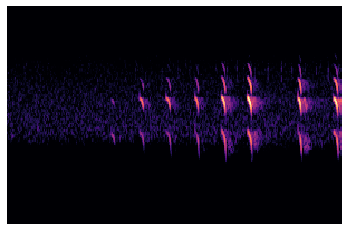

In [32]:
valid_species = ['sample']

audio_folder_name= r"data\Identified calls"
image_folder_name=  r"data\folderLOL"
for sp in valid_species:
    curr_file_names = listdir(join(audio_folder_name,sp))
    print("count of Wav_files in {}= {}".format(len(curr_file_names),sp))
    for f in curr_file_names:
        if f.endswith('.WAV') or f.endswith('.wav'):
            audio_path = join(audio_folder_name,sp,f)
            all_caps_file_name = f.upper()
            image_path = join(image_folder_name,all_caps_file_name.replace('.WAV', '.png'))
            X_img = convert_single_audio_to_image(audio_path,image_path)
            #signal ={f:data}
            #plot_signals(signal)


In [33]:
print(X_img.shape)

(288, 432, 4)
